# Source-only Baseline

In [1]:
# --- Core PyTorch and data handling libraries ---
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torchvision import models, transforms
from datasets import load_dataset

# --- Utility and visualization libraries ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.manifold import TSNE
import copy

# --- Set a random seed for reproducibility ---
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
print("Libraries imported and seed set.")

Libraries imported and seed set.


In [2]:
# --- Configuration ---
SOURCE_DOMAIN = 'photo'
TARGET_DOMAIN = 'sketch'
BATCH_SIZE = 32
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Running on device: {device}")

# --- Load Raw Data from Hugging Face ---
print("\nLoading PACS dataset from Hugging Face...")
full_dataset = load_dataset("flwrlabs/pacs", split='train', trust_remote_code=True)
class_names = full_dataset.features['label'].names
num_classes = len(class_names)

# --- Filter for our specific domains ---
source_data = full_dataset.filter(lambda example: example['domain'] == SOURCE_DOMAIN)
target_data = full_dataset.filter(lambda example: example['domain'] == TARGET_DOMAIN)

# --- Define Image Transformations ---
data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# --- Define the ROBUST Collate Function ---
def custom_collate_fn(batch):
    """Takes a list of samples and collates them into a batch, applying transforms."""
    pixel_values = torch.stack([data_transforms(item['image'].convert("RGB")) for item in batch])
    labels = torch.tensor([item['label'] for item in batch])
    return {'pixel_values': pixel_values, 'label': labels}

# --- Create Final DataLoaders ---
# drop_last=True is essential for domain adaptation methods where batches must have equal sizes.
source_loader = DataLoader(source_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=custom_collate_fn, drop_last=True)
target_loader = DataLoader(target_data, batch_size=BATCH_SIZE, shuffle=False, collate_fn=custom_collate_fn, drop_last=True)
print("DataLoaders created with robust collate_fn.")

`trust_remote_code` is not supported anymore.
Please check that the Hugging Face dataset 'flwrlabs/pacs' isn't based on a loading script and remove `trust_remote_code`.
If the dataset is based on a loading script, please ask the dataset author to remove it and convert it to a standard format like Parquet.


Running on device: cuda:0

Loading PACS dataset from Hugging Face...


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/191M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/9991 [00:00<?, ? examples/s]

Filter:   0%|          | 0/9991 [00:00<?, ? examples/s]

Filter:   0%|          | 0/9991 [00:00<?, ? examples/s]

DataLoaders created with robust collate_fn.


In [3]:
# --- Define the Training Loop ---
def train_model(model, dataloader, criterion, optimizer, num_epochs=10):
    print("\n--- Starting Model Training ---")
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        running_corrects = 0
        for batch in dataloader:
            inputs, labels = batch['pixel_values'].to(device), batch['label'].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            _, preds = torch.max(outputs, 1)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)
        
        epoch_loss = running_loss / len(dataloader.dataset)
        epoch_acc = running_corrects.double() / len(dataloader.dataset)
        print(f'Epoch {epoch+1}/{num_epochs} -> Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
    
    print("--- Training Complete ---")
    return model

# --- Create and Train the Baseline Model ---
baseline_model = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
for param in baseline_model.parameters():
    param.requires_grad = False
num_ftrs = baseline_model.fc.in_features
baseline_model.fc = nn.Linear(num_ftrs, num_classes)
baseline_model = baseline_model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(baseline_model.fc.parameters(), lr=0.001)

baseline_model_trained = train_model(baseline_model, source_loader, criterion, optimizer, num_epochs=10)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 179MB/s] 



--- Starting Model Training ---
Epoch 1/10 -> Loss: 0.5348 Acc: 0.8808
Epoch 2/10 -> Loss: 0.1058 Acc: 0.9802
Epoch 3/10 -> Loss: 0.0715 Acc: 0.9796
Epoch 4/10 -> Loss: 0.0566 Acc: 0.9832
Epoch 5/10 -> Loss: 0.0471 Acc: 0.9880
Epoch 6/10 -> Loss: 0.0361 Acc: 0.9898
Epoch 7/10 -> Loss: 0.0319 Acc: 0.9904
Epoch 8/10 -> Loss: 0.0303 Acc: 0.9898
Epoch 9/10 -> Loss: 0.0277 Acc: 0.9886
Epoch 10/10 -> Loss: 0.0280 Acc: 0.9910
--- Training Complete ---


In [4]:
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.manifold import TSNE
from torch.utils.data import TensorDataset, DataLoader
from collections import Counter
import pandas as pd
import seaborn as sns

# ===================================================================
# SECTION A: UTILITY FUNCTIONS (Corrected and Scoped for Baseline)
# ===================================================================

def get_feature_extractor(model):
    """Gets the feature extractor from a standard torchvision model."""
    # This version is simplified for now. We will enhance it later for DANN/CDAN.
    return nn.Sequential(*list(model.children())[:-1])

def get_model_predictions(model, dataloader, device):
    """Gets all predictions and labels from a standard model."""
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        # Corrected the typo from 'dataloaloader' to 'dataloader'
        for batch in dataloader:
            inputs, labels = batch['pixel_values'].to(device), batch['label'].to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return np.array(all_preds), np.array(all_labels)

# ===================================================================
# SECTION B: CORE METRIC CALCULATION FUNCTIONS
# ===================================================================

def evaluate_model(model, dataloader):
    """Standard evaluation function for simple models."""
    model.eval()
    running_corrects = 0
    with torch.no_grad():
        for batch in dataloader:
            inputs, labels = batch['pixel_values'].to(device), batch['label'].to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)
    # Correctly calculate accuracy based on the number of samples in the dataloader
    accuracy = running_corrects.double() / len(dataloader.dataset)
    return accuracy.item()

def calculate_source_accuracy(model, source_loader, device):
    """Calculates accuracy on the source domain."""
    preds, labels = get_model_predictions(model, source_loader, device)
    accuracy = np.sum(preds == labels) / len(labels)
    return accuracy

def calculate_rare_f1(model, target_loader, rare_class_indices, device):
    """Calculates the macro F1-score for the three rarest classes."""
    preds, labels = get_model_predictions(model, target_loader, device)
    mask = np.isin(labels, rare_class_indices)
    if np.sum(mask) == 0: return 0.0
    f1 = f1_score(labels[mask], preds[mask], average='macro', labels=rare_class_indices, zero_division=0)
    return f1

# ===================================================================
# SECTION C: PROXY-DISTANCE CALCULATION
# ===================================================================

class DomainClassifier(nn.Module):
    """A simple MLP used for the proxy-distance calculation."""
    def __init__(self, input_features=2048):
        super(DomainClassifier, self).__init__()
        self.layer = nn.Sequential(nn.Linear(input_features, 512), nn.ReLU(), nn.Dropout(0.5), nn.Linear(512, 1))
    def forward(self, x): return self.layer(x)

def calculate_proxy_distance(model, source_loader, target_loader, device):
    """Trains a classifier to distinguish domain features. Its accuracy serves as a proxy for domain distance."""
    print(f"Calculating Proxy-Distance for {type(model).__name__}...")
    feature_extractor = get_feature_extractor(model).to(device).eval()
    
    # Use torch.no_grad() for feature extraction to save memory
    with torch.no_grad():
        source_features = torch.cat([feature_extractor(batch['pixel_values'].to(device)).view(batch['pixel_values'].size(0), -1) for batch in source_loader])
        target_features = torch.cat([feature_extractor(batch['pixel_values'].to(device)).view(batch['pixel_values'].size(0), -1) for batch in target_loader])
    
    features = torch.cat([source_features, target_features])
    labels = torch.cat([torch.zeros(source_features.size(0)), torch.ones(target_features.size(0))]).unsqueeze(1)
    
    domain_dataset = TensorDataset(features, labels)
    domain_loader = DataLoader(domain_dataset, batch_size=64, shuffle=True)
    
    domain_clf = DomainClassifier().to(device)
    optimizer = optim.Adam(domain_clf.parameters(), lr=0.001)
    criterion = nn.BCEWithLogitsLoss()
    
    for epoch in range(5):
        for f, l in domain_loader:
            optimizer.zero_grad()
            outputs = domain_clf(f)
            loss = criterion(outputs, l.to(device))
            loss.backward()
            optimizer.step()
            
    total_correct = 0
    with torch.no_grad():
        for f, l in domain_loader:
            preds = (torch.sigmoid(domain_clf(f.to(device))) > 0.5).float()
            total_correct += (preds == l.to(device)).sum().item()
            
    accuracy = total_correct / len(domain_dataset)
    print(f"-> Proxy-Distance (Classifier Accuracy): {accuracy:.4f}")
    return accuracy

# ===================================================================
# SECTION D: VISUALIZATION FUNCTIONS
# ===================================================================

def generate_tsne_plot(model, source_loader, target_loader, title):
    """t-SNE plotter for standard models."""
    print("Generating t-SNE plot...")
    feature_extractor = get_feature_extractor(model).to(device).eval()
    all_features, all_domain_labels = [], []
    with torch.no_grad():
        for batch in source_loader:
            features = feature_extractor(batch['pixel_values'].to(device)).view(batch['pixel_values'].size(0), -1)
            all_features.append(features.cpu().numpy())
            all_domain_labels.extend([0] * features.size(0))
        for batch in target_loader:
            features = feature_extractor(batch['pixel_values'].to(device)).view(batch['pixel_values'].size(0), -1)
            all_features.append(features.cpu().numpy())
            all_domain_labels.extend([1] * features.size(0))
    tsne_results = TSNE(n_components=2, random_state=SEED, perplexity=30, n_iter=300, init='pca').fit_transform(np.concatenate(all_features))
    plt.figure(figsize=(10, 8))
    scatter = sns.scatterplot(x=tsne_results[:, 0], y=tsne_results[:, 1], hue=all_domain_labels, palette={0: 'red', 1: 'cyan'}, s=50, alpha=0.8)
    handles, _ = scatter.get_legend_handles_labels()
    plt.legend(handles, ['Source (Photo)', 'Target (Sketch)'], title='Domain', fontsize='12', title_fontsize='13', facecolor='white', edgecolor='black')
    plt.title(title, fontsize=15)
    plt.xlabel("t-SNE Dimension 1", fontsize=12)
    plt.ylabel("t-SNE Dimension 2", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(model, dataloader, class_names, title):
    """Confusion matrix plotter for standard models."""
    print("Generating confusion matrix...")
    preds, labels = get_model_predictions(model, dataloader, device)
    cm = confusion_matrix(labels, preds)
    cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    plt.title(title, fontsize=15)
    plt.ylabel('Actual Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.show()

print("Comprehensive analysis suite defined successfully.")

Comprehensive analysis suite defined successfully.


In [5]:
# IMPORTANT: Make sure the analysis functions from our previous discussion are defined in your notebook.
# (get_feature_extractor, get_model_predictions, calculate_source_accuracy,
# calculate_rare_f1, calculate_proxy_distance, etc.)

# --- 1. Identify Rarest Classes ---
target_class_counts = Counter(target_data['label'])
rarest_classes = target_class_counts.most_common()[-3:]
rarest_class_indices = [item[0] for item in rarest_classes]
print(f"Identified rarest classes: {[class_names[i] for i in rarest_class_indices]}")

# --- 2. Run Full Analysis on the Baseline Model ---
print("\n--- Comprehensive Analysis of Baseline Model ---")
baseline_results = {}

# Standard evaluation
target_acc = evaluate_model(baseline_model_trained, target_loader)
source_acc = calculate_source_accuracy(baseline_model_trained, source_loader, device)
rare_f1 = calculate_rare_f1(baseline_model_trained, target_loader, rarest_class_indices, device)
proxy_dist = calculate_proxy_distance(baseline_model_trained, source_loader, target_loader, device)

baseline_results['Baseline'] = {
    'Target Acc.': f"{target_acc:.2%}",
    'Source Acc.': f"{source_acc:.2%}",
    'Rare Class F1': f"{rare_f1:.4f}",
    'Proxy-Distance': f"{proxy_dist:.2%}"
}

# --- 3. Display Results Table ---
results_df = pd.DataFrame(baseline_results).T
print("\n--- Baseline Analysis Results ---")
print(results_df)

Identified rarest classes: ['guitar', 'person', 'house']

--- Comprehensive Analysis of Baseline Model ---
Calculating Proxy-Distance for ResNet...
-> Proxy-Distance (Classifier Accuracy): 1.0000

--- Baseline Analysis Results ---
         Target Acc. Source Acc. Rare Class F1 Proxy-Distance
Baseline      32.83%     100.00%        0.3074        100.00%


Generating t-SNE plot...


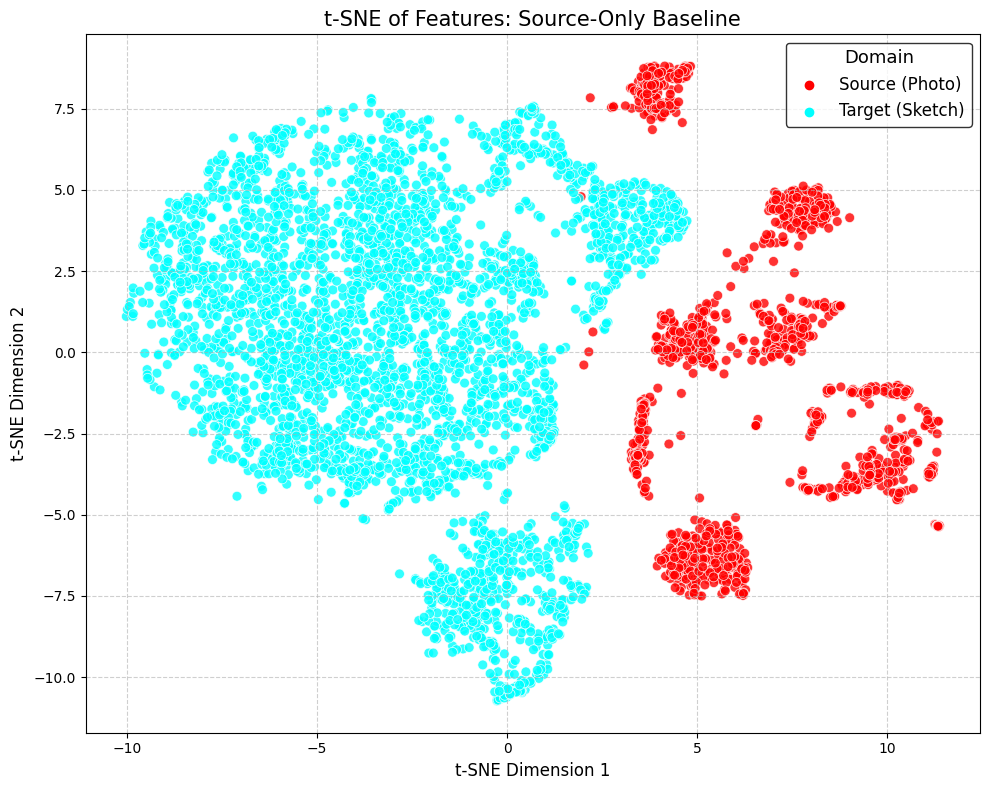

In [6]:
# --- 4. Generate Visualizations ---
generate_tsne_plot(baseline_model_trained, source_loader, target_loader, "t-SNE of Features: Source-Only Baseline")

Generating confusion matrix...


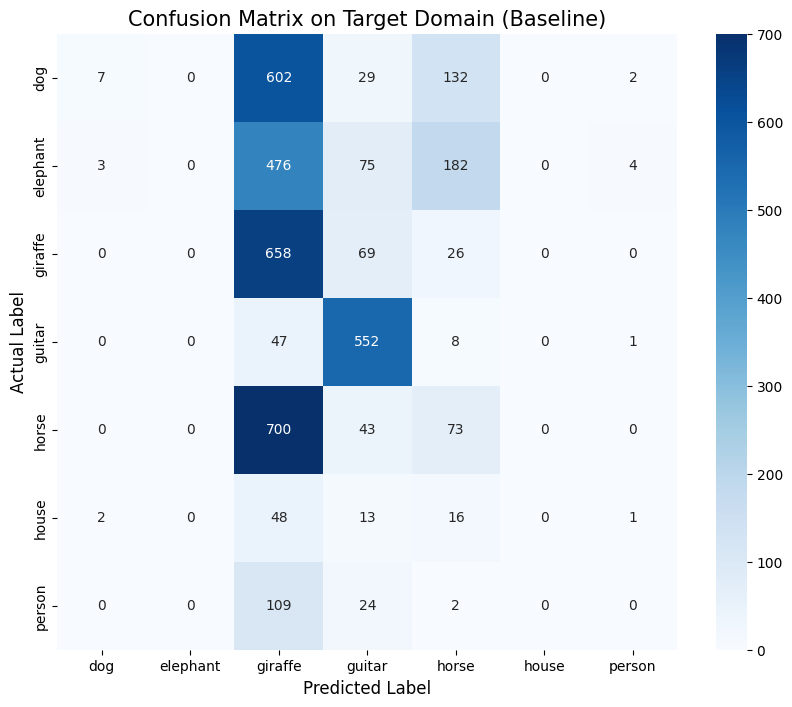

In [7]:
plot_confusion_matrix(baseline_model_trained, target_loader, class_names, "Confusion Matrix on Target Domain (Baseline)")

# Domain Adversarial Neural Network (DANN)

In [8]:
from torch.autograd import Function
import math

# --- Component 1: Gradient Reversal Layer (GRL) ---
# This implementation is standard and correct.
class GradientReversalFunction(Function):
    @staticmethod
    def forward(ctx, input, alpha):
        ctx.alpha = alpha
        return input.clone()
    @staticmethod
    def backward(ctx, grad_output):
        grad_input = grad_output.neg() * ctx.alpha
        return grad_input, None
class GradientReversalLayer(nn.Module):
    def forward(self, input, alpha=1.0):
        return GradientReversalFunction.apply(input, alpha)

# --- Component 2: Domain Discriminator ---
# This is a standard MLP architecture suitable for the task.
class DomainDiscriminator(nn.Module):
    def __init__(self, input_features=2048):
        super(DomainDiscriminator, self).__init__()
        self.layer = nn.Sequential(
            nn.Linear(input_features, 1024), nn.ReLU(inplace=True), nn.Dropout(0.5),
            nn.Linear(1024, 1024), nn.ReLU(inplace=True), nn.Dropout(0.5),
            nn.Linear(1024, 1)
        )
    def forward(self, x): return self.layer(x)

# --- Component 3: The Full DANN Model ---
# This class correctly assembles the components.
class DANN_Model(nn.Module):
    def __init__(self, num_classes=7):
        super(DANN_Model, self).__init__()
        resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        self.feature_extractor = nn.Sequential(*list(resnet.children())[:-1])
        self.label_classifier = nn.Linear(resnet.fc.in_features, num_classes)
        self.domain_discriminator = DomainDiscriminator(input_features=resnet.fc.in_features)
        self.grl = GradientReversalLayer()

    def forward(self, x, alpha=1.0):
        features = self.feature_extractor(x).view(x.size(0), -1)
        class_output = self.label_classifier(features)
        reversed_features = self.grl(features, alpha)
        domain_output = self.domain_discriminator(reversed_features)
        return class_output, domain_output

In [9]:
def train_dann(model, source_loader, target_loader, device, num_epochs=15):
    """
    A professional training loop for DANN with separate optimizers for stability.
    """
    print("\n--- Starting DANN Training ---")
    
    # --- Separate optimizers for stability ---
    optimizer_main = optim.SGD(
        list(model.feature_extractor.parameters()) + list(model.label_classifier.parameters()),
        lr=0.001, momentum=0.9, weight_decay=0.0005
    )
    optimizer_disc = optim.Adam(
        model.domain_discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999)
    )
    
    class_criterion = nn.CrossEntropyLoss()
    domain_criterion = nn.BCEWithLogitsLoss()
    
    len_dataloader = min(len(source_loader), len(target_loader))
    total_steps = num_epochs * len_dataloader
    
    model.train()
    for epoch in range(num_epochs):
        for i, (source_batch, target_batch) in enumerate(zip(source_loader, target_loader)):
            source_inputs, source_labels = source_batch['pixel_values'].to(device), source_batch['label'].to(device)
            target_inputs = target_batch['pixel_values'].to(device)
            
            source_domain_labels = torch.zeros(source_inputs.size(0), 1, device=device)
            target_domain_labels = torch.ones(target_inputs.size(0), 1, device=device)
            
            p = float(i + epoch * len_dataloader) / total_steps
            alpha = 2. / (1. + math.exp(-10 * p)) - 1
            
            optimizer_main.zero_grad()
            optimizer_disc.zero_grad()
            
            # Forward pass for source data
            class_output_s, domain_output_s = model(source_inputs, alpha)
            err_s_label = class_criterion(class_output_s, source_labels)
            err_s_domain = domain_criterion(domain_output_s, source_domain_labels)
            
            # Forward pass for target data
            _, domain_output_t = model(target_inputs, alpha)
            err_t_domain = domain_criterion(domain_output_t, target_domain_labels)
            
            # Combine losses and backpropagate
            domain_loss = err_s_domain + err_t_domain
            total_loss = err_s_label + domain_loss
            total_loss.backward()
            
            # Step both optimizers
            optimizer_main.step()
            optimizer_disc.step()
            
        print(f"Epoch [{epoch+1}/{num_epochs}], Class Loss: {err_s_label.item():.4f}, Domain Loss: {domain_loss.item():.4f}")

    print("--- DANN Training Complete ---")
    return model

# --- Instantiate and Train the DANN Model ---
dann_model = DANN_Model(num_classes=num_classes).to(device)
dann_model_trained = train_dann(dann_model, source_loader, target_loader, device, num_epochs=15)


--- Starting DANN Training ---
Epoch [1/15], Class Loss: 0.1259, Domain Loss: 0.3690
Epoch [2/15], Class Loss: 0.2118, Domain Loss: 1.3199
Epoch [3/15], Class Loss: 0.1501, Domain Loss: 1.0841
Epoch [4/15], Class Loss: 0.1204, Domain Loss: 1.2933
Epoch [5/15], Class Loss: 0.0808, Domain Loss: 1.1328
Epoch [6/15], Class Loss: 0.0365, Domain Loss: 1.2948
Epoch [7/15], Class Loss: 0.0080, Domain Loss: 1.3405
Epoch [8/15], Class Loss: 0.0221, Domain Loss: 1.3871
Epoch [9/15], Class Loss: 0.0172, Domain Loss: 1.2243
Epoch [10/15], Class Loss: 0.0168, Domain Loss: 1.3476
Epoch [11/15], Class Loss: 0.0118, Domain Loss: 1.3184
Epoch [12/15], Class Loss: 0.0478, Domain Loss: 1.3356
Epoch [13/15], Class Loss: 0.0062, Domain Loss: 1.3938
Epoch [14/15], Class Loss: 0.0037, Domain Loss: 1.3319
Epoch [15/15], Class Loss: 0.0129, Domain Loss: 1.3910
--- DANN Training Complete ---


In [10]:
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.manifold import TSNE
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import seaborn as sns

# ===================================================================
# ANALYSIS SUITE (Scoped for Baseline and DANN Models)
# ===================================================================

def get_feature_extractor(model):
    """Gets the feature extractor from either a standard ResNet or our DANN_Model."""
    if isinstance(model, DANN_Model):
        return model.feature_extractor
    else:
        return nn.Sequential(*list(model.children())[:-1])

def get_model_predictions(model, dataloader, device):
    """A universal helper function for Baseline and DANN models."""
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in dataloader:
            inputs, labels = batch['pixel_values'].to(device), batch['label'].to(device)
            if isinstance(model, DANN_Model):
                class_output, _ = model(inputs, alpha=0)
            else:
                class_output = model(inputs)
            _, preds = torch.max(class_output, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return np.array(all_preds), np.array(all_labels)

# --- The rest of the analysis functions can now use the helpers above ---

def evaluate_target_accuracy(model, target_loader, device):
    preds, labels = get_model_predictions(model, target_loader, device)
    return np.sum(preds == labels) / len(labels)

def calculate_source_accuracy(model, source_loader, device):
    preds, labels = get_model_predictions(model, source_loader, device)
    return np.sum(preds == labels) / len(labels)

def calculate_rare_f1(model, target_loader, rare_class_indices, device):
    preds, labels = get_model_predictions(model, target_loader, device)
    mask = np.isin(labels, rare_class_indices)
    if np.sum(mask) == 0: return 0.0
    return f1_score(labels[mask], preds[mask], average='macro', labels=rare_class_indices, zero_division=0)

class DomainClassifier(nn.Module):
    def __init__(self, input_features=2048):
        super(DomainClassifier, self).__init__()
        self.layer = nn.Sequential(nn.Linear(input_features, 512), nn.ReLU(), nn.Dropout(0.5), nn.Linear(512, 1))
    def forward(self, x): return self.layer(x)

def calculate_proxy_distance(model, source_loader, target_loader, device):
    print(f"Calculating Proxy-Distance for {type(model).__name__}...")
    feature_extractor = get_feature_extractor(model).to(device).eval()
    with torch.no_grad():
        source_features = torch.cat([feature_extractor(b['pixel_values'].to(device)).view(b['pixel_values'].size(0), -1) for b in source_loader])
        target_features = torch.cat([feature_extractor(b['pixel_values'].to(device)).view(b['pixel_values'].size(0), -1) for b in target_loader])
    features = torch.cat([source_features, target_features])
    labels = torch.cat([torch.zeros(source_features.size(0)), torch.ones(target_features.size(0))]).unsqueeze(1)
    domain_dataset = TensorDataset(features, labels)
    domain_loader = DataLoader(domain_dataset, batch_size=64, shuffle=True)
    domain_clf = DomainClassifier().to(device)
    optimizer = optim.Adam(domain_clf.parameters(), lr=0.001)
    criterion = nn.BCEWithLogitsLoss()
    for epoch in range(5):
        for f, l in domain_loader:
            optimizer.zero_grad()
            outputs = domain_clf(f)
            loss = criterion(outputs, l.to(device))
            loss.backward(); optimizer.step()
    total_correct = 0
    with torch.no_grad():
        for f, l in domain_loader:
            preds = (torch.sigmoid(domain_clf(f.to(device))) > 0.5).float()
            total_correct += (preds == l.to(device)).sum().item()
    accuracy = total_correct / len(domain_dataset)
    print(f"-> Proxy-Distance (Classifier Accuracy): {accuracy:.4f}")
    return accuracy

def generate_tsne_plot(model, source_loader, target_loader, title):
    print("Generating t-SNE plot...")
    feature_extractor = get_feature_extractor(model).to(device).eval()
    # (The rest of the function remains the same as the last correct version)
    all_features, all_domain_labels = [], []
    with torch.no_grad():
        for batch in source_loader:
            features = feature_extractor(batch['pixel_values'].to(device)).view(batch['pixel_values'].size(0), -1)
            all_features.append(features.cpu().numpy()); all_domain_labels.extend([0] * features.size(0))
        for batch in target_loader:
            features = feature_extractor(batch['pixel_values'].to(device)).view(batch['pixel_values'].size(0), -1)
            all_features.append(features.cpu().numpy()); all_domain_labels.extend([1] * features.size(0))
    tsne_results = TSNE(n_components=2, random_state=SEED, perplexity=30, n_iter=300, init='pca').fit_transform(np.concatenate(all_features))
    plt.figure(figsize=(10, 8))
    scatter = sns.scatterplot(x=tsne_results[:, 0], y=tsne_results[:, 1], hue=all_domain_labels, palette={0: 'red', 1: 'cyan'}, s=50, alpha=0.8)
    handles, _ = scatter.get_legend_handles_labels()
    plt.legend(handles, ['Source (Photo)', 'Target (Sketch)'], title='Domain', fontsize='12', title_fontsize='13', facecolor='white', edgecolor='black')
    plt.title(title, fontsize=15)
    plt.xlabel("t-SNE Dimension 1"); plt.ylabel("t-SNE Dimension 2")
    plt.grid(True, linestyle='--', alpha=0.6); plt.tight_layout(); plt.show()


def plot_confusion_matrix(model, dataloader, class_names, title):
    print("Generating confusion matrix...")
    preds, labels = get_model_predictions(model, dataloader, device)
    cm = confusion_matrix(labels, preds)
    cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    plt.title(title, fontsize=15)
    plt.ylabel('Actual Label'); plt.xlabel('Predicted Label')
    plt.show()

print("DANN-specific analysis suite defined successfully.")

DANN-specific analysis suite defined successfully.


In [11]:
# --- Run Full Analysis on the DANN Model ---
print("\n--- Comprehensive Analysis of DANN Model ---")
dann_results = {}

# Calculate all required metrics
target_acc = evaluate_target_accuracy(dann_model_trained, target_loader, device)
source_acc = calculate_source_accuracy(dann_model_trained, source_loader, device)
rare_f1 = calculate_rare_f1(dann_model_trained, target_loader, rarest_class_indices, device)
proxy_dist = calculate_proxy_distance(dann_model_trained, source_loader, target_loader, device)

dann_results['DANN'] = {
    'Target Acc.': f"{target_acc:.2%}",
    'Source Acc.': f"{source_acc:.2%}",
    'Rare Class F1': f"{rare_f1:.4f}",
    'Proxy-Distance': f"{proxy_dist:.2%}"
}

# --- Display Updated Results Table ---
# Create the DataFrame from the baseline results if it doesn't exist
# (Assuming baseline_results dictionary was created in the previous step)
if 'results_df' not in locals():
    results_df = pd.DataFrame(baseline_results)
# Append the new DANN results
dann_df = pd.DataFrame(dann_results).T
results_df = pd.concat([results_df, dann_df])
print("\n--- Updated Comprehensive Analysis Results ---")
print(results_df)


--- Comprehensive Analysis of DANN Model ---
Calculating Proxy-Distance for DANN_Model...
-> Proxy-Distance (Classifier Accuracy): 0.9996

--- Updated Comprehensive Analysis Results ---
         Target Acc. Source Acc. Rare Class F1 Proxy-Distance
Baseline      32.83%     100.00%        0.3074        100.00%
DANN          50.72%      94.11%        0.5158         99.96%


Generating t-SNE plot...


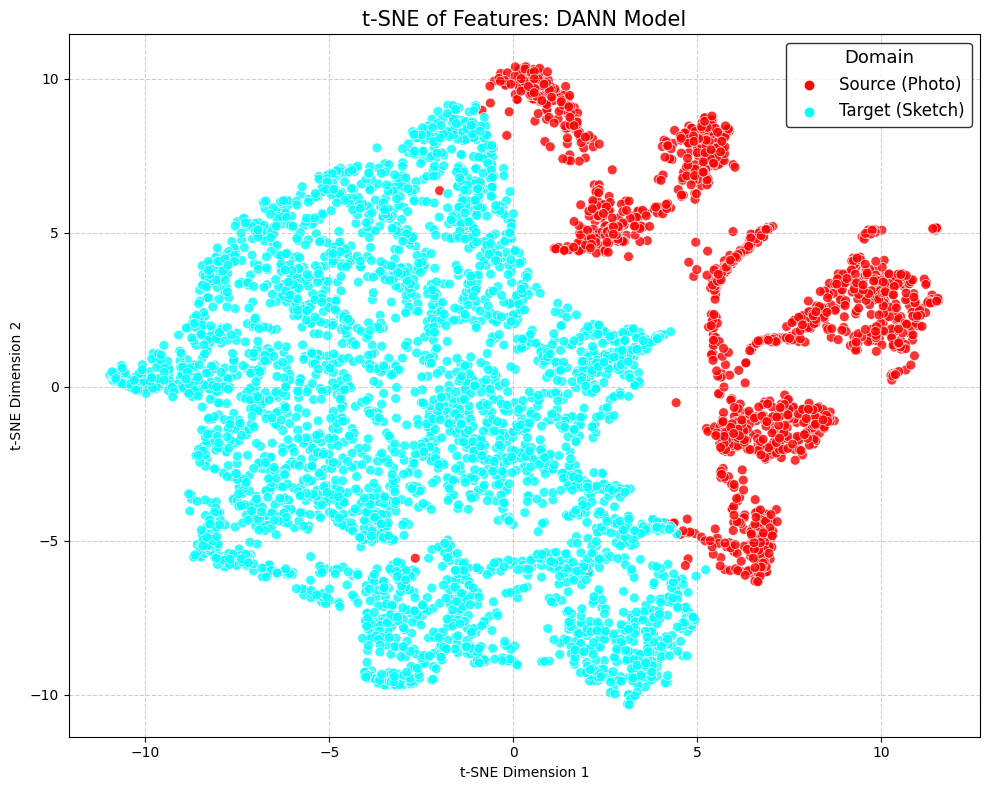

In [12]:
generate_tsne_plot(dann_model_trained, source_loader, target_loader, "t-SNE of Features: DANN Model")

Generating confusion matrix...


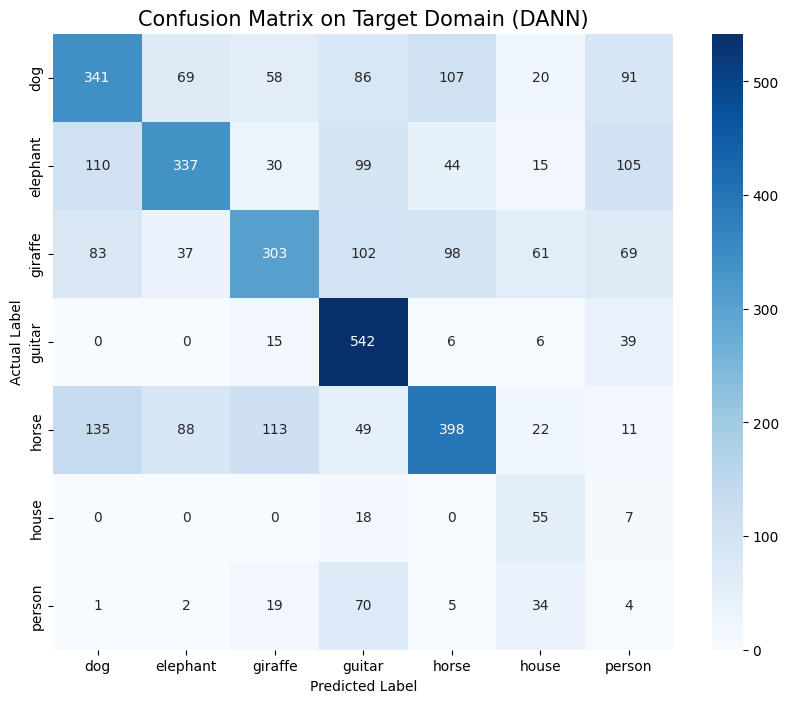

In [13]:
plot_confusion_matrix(dann_model_trained, target_loader, class_names, "Confusion Matrix on Target Domain (DANN)")

# Deep Adaptation Network (DAN)

In [14]:
def linear_mmd_loss(source, target, kernel_mul=2.0, kernel_num=5, fix_sigma=None):
    """
    Calculates the linear-time, multi-kernel MMD loss, faithful to the DAN paper.
    """
    batch_size = source.size(0)
    # Ensure even batch size for pairing
    if batch_size % 2 != 0:
        batch_size = batch_size - 1
        source = source[:batch_size]
        target = target[:batch_size]
        
    kernels = gaussian_kernel(source, target, kernel_mul=kernel_mul, kernel_num=kernel_num, fix_sigma=fix_sigma)
    
    # The linear-time MMD formula from the paper
    loss = 0
    for i in range(batch_size // 2):
        s1, s2 = i * 2, i * 2 + 1
        t1, t2 = s1 + batch_size, s2 + batch_size
        
        # Sum of quad-tuples
        loss += kernels[s1, s2] + kernels[t1, t2]
        loss -= kernels[s1, t2] + kernels[s2, t1]
        
    return loss / (batch_size / 2)

# We still need the gaussian_kernel function from before
def gaussian_kernel(source, target, kernel_mul=2.0, kernel_num=5, fix_sigma=None):
    n_samples = int(source.size()[0]) + int(target.size()[0])
    total = torch.cat([source, target], dim=0)
    total0 = total.unsqueeze(0).expand(int(total.size(0)), int(total.size(0)), int(total.size(1)))
    total1 = total.unsqueeze(1).expand(int(total.size(0)), int(total.size(0)), int(total.size(1)))
    L2_distance = ((total0-total1)**2).sum(2)
    if fix_sigma:
        bandwidth = fix_sigma
    else:
        bandwidth = torch.sum(L2_distance.data) / (n_samples**2-n_samples)
    bandwidth /= kernel_mul ** (kernel_num // 2)
    bandwidth_list = [bandwidth * (kernel_mul**i) for i in range(kernel_num)]
    kernel_val = [torch.exp(-L2_distance / bandwidth_temp) for bandwidth_temp in bandwidth_list]
    return sum(kernel_val)


def stable_mmd_loss(source, target, kernel_mul=2.0, kernel_num=5, fix_sigma=None):
    """
    Calculates the stable, quadratic-time, multi-kernel MMD loss.
    This version is guaranteed to be non-negative.
    """
    batch_size = int(source.size()[0])
    kernels = gaussian_kernel(source, target,
                              kernel_mul=kernel_mul,
                              kernel_num=kernel_num,
                              fix_sigma=fix_sigma)
    
    # Split the kernel matrix
    XX = kernels[:batch_size, :batch_size]
    YY = kernels[batch_size:, batch_size:]
    XY = kernels[:batch_size, batch_size:]
    
    # The MMD formula based on the kernel trick is guaranteed non-negative
    loss = torch.mean(XX + YY - 2 * XY)
    return loss

In [15]:
class DAN_Model(nn.Module):
    """A DAN model that exposes multiple layers for adaptation."""
    def __init__(self, num_classes=7):
        super(DAN_Model, self).__init__()
        resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        self.feature_extractor = nn.Sequential(*list(resnet.children())[:-1])
        self.classifier = nn.Linear(resnet.fc.in_features, num_classes)

    def forward(self, x):
        features = self.feature_extractor(x).view(x.size(0), -1)
        class_output = self.classifier(features)
        # Return both outputs for multi-layer adaptation
        return features, class_output

In [16]:
def train_dan_stable(model, source_loader, target_loader, device, num_epochs=15, mmd_weight=1.0):
    """
    The final, stable training loop for DAN, using the quadratic MMD for stability.
    """
    print("\n--- Starting Final, Stable DAN Training ---")
    
    # Optimizer setup as per the paper
    optimizer = optim.SGD([
        {'params': model.feature_extractor.parameters(), 'lr': 0.001},
        {'params': model.classifier.parameters(), 'lr': 0.01} # 10x higher LR
    ], momentum=0.9, weight_decay=0.0005)
    
    class_criterion = nn.CrossEntropyLoss()
    model.train()

    for epoch in range(num_epochs):
        for i, (source_batch, target_batch) in enumerate(zip(source_loader, target_loader)):
            source_inputs, source_labels = source_batch['pixel_values'].to(device), source_batch['label'].to(device)
            target_inputs = target_batch['pixel_values'].to(device)
            
            optimizer.zero_grad()
            
            # Forward pass to get features from multiple layers
            source_features, source_output = model(source_inputs)
            target_features, target_output = model(target_inputs)
            
            # 1. Classification Loss
            classification_loss = class_criterion(source_output, source_labels)
            
            # 2. MMD Loss on multiple layers using the STABLE function
            mmd_loss_features = stable_mmd_loss(source_features, target_features)
            mmd_loss_classifier = stable_mmd_loss(source_output, target_output)
            
            # Combine losses
            total_loss = classification_loss + mmd_weight * (mmd_loss_features + mmd_loss_classifier)
            
            total_loss.backward()
            optimizer.step()
            
        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Class Loss: {classification_loss.item():.4f}, "
              f"Stable MMD (Features): {mmd_loss_features.item():.4f}, "
              f"Stable MMD (Classifier): {mmd_loss_classifier.item():.4f}")

    print("--- DAN Training Complete ---")
    return model

# --- Instantiate a fresh model and train it ---
dan_model = DAN_Model(num_classes=num_classes).to(device)
dan_model_trained = train_dan_stable(dan_model, source_loader, target_loader, device, num_epochs=15)


--- Starting Final, Stable DAN Training ---
Epoch [1/15], Class Loss: 0.5122, Stable MMD (Features): 0.1658, Stable MMD (Classifier): 0.1722
Epoch [2/15], Class Loss: 0.0986, Stable MMD (Features): 0.1517, Stable MMD (Classifier): 0.1782
Epoch [3/15], Class Loss: 0.0356, Stable MMD (Features): 0.1416, Stable MMD (Classifier): 0.1359
Epoch [4/15], Class Loss: 0.0630, Stable MMD (Features): 0.1341, Stable MMD (Classifier): 0.0913
Epoch [5/15], Class Loss: 0.0474, Stable MMD (Features): 0.1333, Stable MMD (Classifier): 0.0870
Epoch [6/15], Class Loss: 0.0997, Stable MMD (Features): 0.1302, Stable MMD (Classifier): 0.1034
Epoch [7/15], Class Loss: 0.0522, Stable MMD (Features): 0.1292, Stable MMD (Classifier): 0.0996
Epoch [8/15], Class Loss: 0.0369, Stable MMD (Features): 0.1311, Stable MMD (Classifier): 0.1443
Epoch [9/15], Class Loss: 0.0617, Stable MMD (Features): 0.1277, Stable MMD (Classifier): 0.0917
Epoch [10/15], Class Loss: 0.0323, Stable MMD (Features): 0.1258, Stable MMD (Clas

In [17]:
# --- Update the Universal Prediction Function ---
def get_model_predictions(model, dataloader, device):
    """Gets all predictions and labels from any model type we use."""
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in dataloader:
            inputs, labels = batch['pixel_values'].to(device), batch['label'].to(device)
            if isinstance(model, DANN_Model): # Scoped for DANN
                class_output, _ = model(inputs, alpha=0)
            elif isinstance(model, DAN_Model): # ADDED: Handle the new DAN model
                _, class_output = model(inputs)
            else: # Standard models
                class_output = model(inputs)
            _, preds = torch.max(class_output, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return np.array(all_preds), np.array(all_labels)

In [18]:
# --- Run Full Analysis on the DAN Model ---
print("\n--- Comprehensive Analysis of DAN Model ---")
dan_results = {}

target_acc = evaluate_target_accuracy(dan_model_trained, target_loader, device)
source_acc = calculate_source_accuracy(dan_model_trained, source_loader, device)
rare_f1 = calculate_rare_f1(dan_model_trained, target_loader, rarest_class_indices, device)
proxy_dist = calculate_proxy_distance(dan_model_trained, source_loader, target_loader, device)

dan_results['DAN'] = {
    'Target Acc.': f"{target_acc:.2%}",
    'Source Acc.': f"{source_acc:.2%}",
    'Rare Class F1': f"{rare_f1:.4f}",
    'Proxy-Distance': f"{proxy_dist:.2%}"
}

# --- Display Updated Results Table ---
dan_df = pd.DataFrame(dan_results).T
results_df = pd.concat([results_df, dan_df])
print("\n--- Updated Comprehensive Analysis Results ---")
print(results_df)


--- Comprehensive Analysis of DAN Model ---
Calculating Proxy-Distance for DAN_Model...
-> Proxy-Distance (Classifier Accuracy): 1.0000

--- Updated Comprehensive Analysis Results ---
         Target Acc. Source Acc. Rare Class F1 Proxy-Distance
Baseline      32.83%     100.00%        0.3074        100.00%
DANN          50.72%      94.11%        0.5158         99.96%
DAN           40.50%      95.73%        0.4974        100.00%


Generating t-SNE plot...


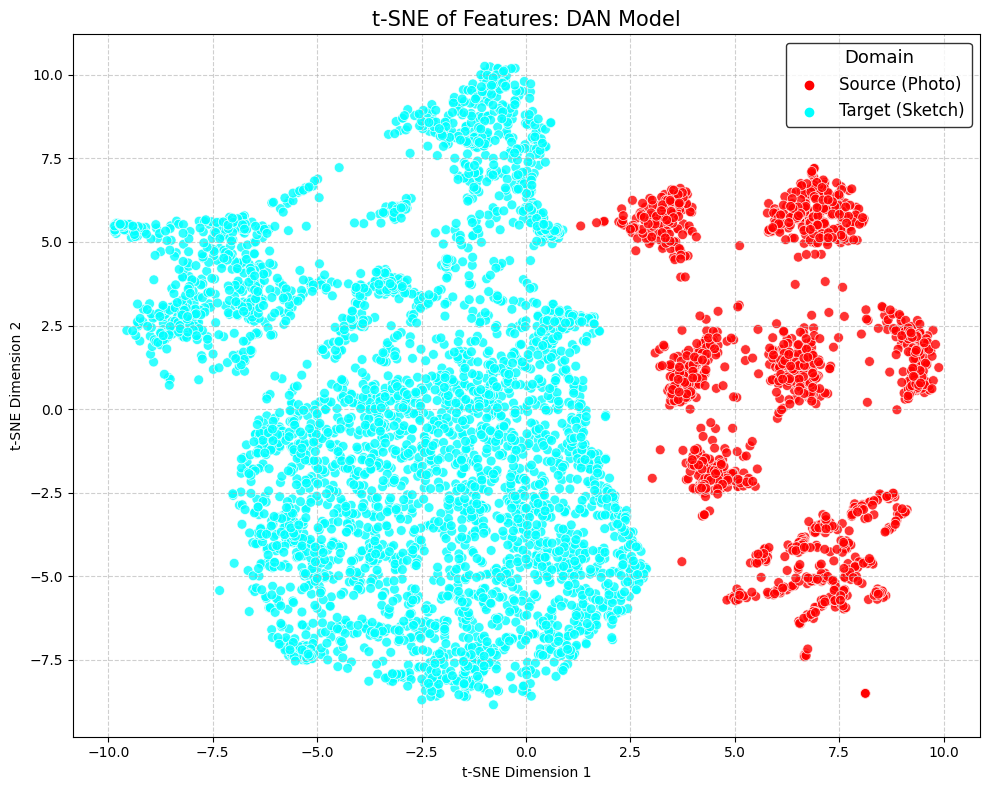

In [19]:
# --- Generate Visualizations ---
generate_tsne_plot(dan_model_trained, source_loader, target_loader, "t-SNE of Features: DAN Model")

Generating confusion matrix...


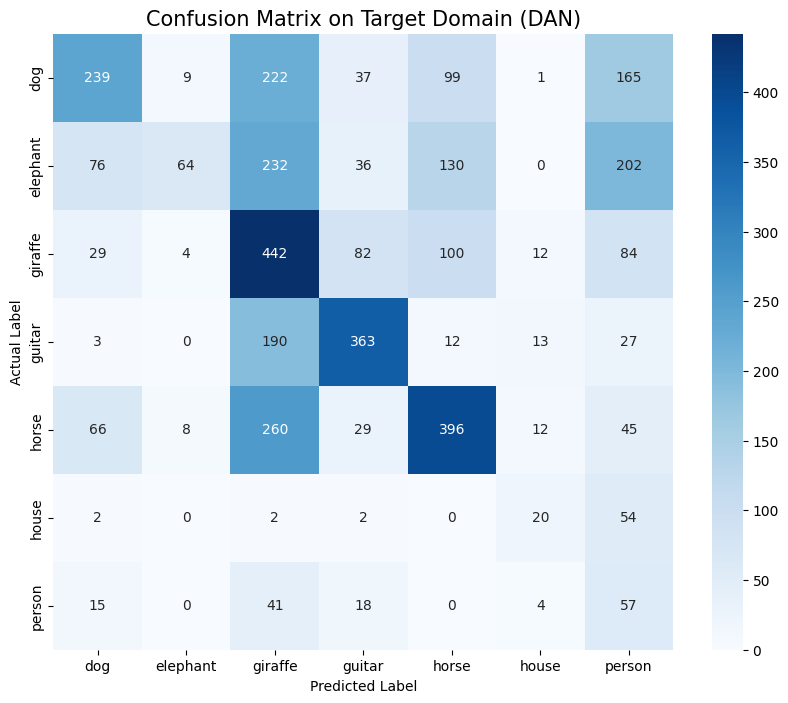

In [20]:
plot_confusion_matrix(dan_model_trained, target_loader, class_names, "Confusion Matrix on Target Domain (DAN)")

# Conditional Domain Adversarial Network (CDAN)

In [21]:
# --- Component 1: Gradient Reversal Layer (GRL) ---
# Assumed to be defined from the DANN section. If not, add it here.
# class GradientReversalLayer(nn.Module): ...

# --- Component 2: The CDAN Discriminator ---
class CDAN_DomainDiscriminator(nn.Module):
    def __init__(self, feature_dim=2048, num_classes=7):
        super(CDAN_DomainDiscriminator, self).__init__()
        self.input_features = feature_dim * num_classes
        self.layer = nn.Sequential(
            nn.Linear(self.input_features, 1024), nn.ReLU(inplace=True), nn.Dropout(0.5),
            nn.Linear(1024, 1024), nn.ReLU(inplace=True), nn.Dropout(0.5),
            nn.Linear(1024, 1)
        )
    def forward(self, x): return self.layer(x)

# --- Component 3: The Final CDAN_Model Class ---
class CDAN_Model(nn.Module):
    def __init__(self, num_classes=7):
        super(CDAN_Model, self).__init__()
        resnet = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)
        self.feature_extractor = nn.Sequential(*list(resnet.children())[:-1])
        self.label_classifier = nn.Linear(resnet.fc.in_features, num_classes)
        self.domain_discriminator = CDAN_DomainDiscriminator(feature_dim=resnet.fc.in_features, num_classes=num_classes)
        self.grl = GradientReversalLayer()

    def forward(self, x, alpha=1.0, return_softmax=False):
        features = self.feature_extractor(x).view(x.size(0), -1)
        class_output = self.label_classifier(features)
        softmax_output = nn.Softmax(dim=1)(class_output)
        
        # The core of CDAN: multilinear map
        reversed_features = self.grl(features, alpha)
        op = torch.bmm(softmax_output.unsqueeze(2), reversed_features.unsqueeze(1))
        combined_features = op.view(-1, softmax_output.size(1) * reversed_features.size(1))
        domain_output = self.domain_discriminator(combined_features)
        
        if return_softmax:
            return class_output, domain_output, softmax_output
        else:
            return class_output, domain_output

# --- Helper for Entropy Calculation ---
def calculate_entropy(predictions):
    return -torch.sum(predictions * torch.log(predictions + 1e-5), dim=1)

print("CDAN+E model architecture defined successfully.")

CDAN+E model architecture defined successfully.


In [22]:
def train_cdan_professional(model, source_loader, target_loader, device, num_epochs=15):
    """
    A professional training loop for CDAN+E, faithful to the original paper's methodology.
    """
    print("\n--- Starting Paper-Adherent CDAN+E Training ---")
    
    optimizer = optim.SGD([
        {'params': model.feature_extractor.parameters(), 'lr': 0.001},
        {'params': model.label_classifier.parameters(), 'lr': 0.01},
        {'params': model.domain_discriminator.parameters(), 'lr': 0.001}
    ], momentum=0.9, weight_decay=0.0005)

    class_criterion = nn.CrossEntropyLoss()
    domain_criterion = nn.BCEWithLogitsLoss()
    model.train()

    len_dataloader = min(len(source_loader), len(target_loader))
    total_steps = num_epochs * len_dataloader

    for epoch in range(num_epochs):
        for i, (source_batch, target_batch) in enumerate(zip(source_loader, target_loader)):
            p = float(i + epoch * len_dataloader) / total_steps
            lr = 0.01 / (1. + 10 * p)**0.75
            optimizer.param_groups[0]['lr'] = lr / 10
            optimizer.param_groups[1]['lr'] = lr
            optimizer.param_groups[2]['lr'] = lr
            alpha = 2. / (1. + math.exp(-10 * p)) - 1
            
            source_inputs, source_labels = source_batch['pixel_values'].to(device), source_batch['label'].to(device)
            target_inputs = target_batch['pixel_values'].to(device)
            source_domain_labels = torch.zeros(source_inputs.size(0), 1, device=device)
            target_domain_labels = torch.ones(target_inputs.size(0), 1, device=device)
            
            optimizer.zero_grad()
            
            class_output_s, domain_output_s, softmax_s = model(source_inputs, alpha, return_softmax=True)
            err_s_label = class_criterion(class_output_s, source_labels)
            
            _, domain_output_t, softmax_t = model(target_inputs, alpha, return_softmax=True)
            
            entropy_s = calculate_entropy(softmax_s)
            entropy_t = calculate_entropy(softmax_t)
            entropy_weight_s = 1 + torch.exp(-entropy_s)
            entropy_weight_t = 1 + torch.exp(-entropy_t)
            
            err_s_domain = domain_criterion(domain_output_s, source_domain_labels)
            err_t_domain = domain_criterion(domain_output_t, target_domain_labels)
            domain_loss = torch.mean(entropy_weight_s * err_s_domain) + torch.mean(entropy_weight_t * err_t_domain)
            
            total_loss = err_s_label + domain_loss
            total_loss.backward()
            optimizer.step()
            
        print(f"Epoch [{epoch+1}/{num_epochs}], Class Loss: {err_s_label.item():.4f}, Domain Loss: {domain_loss.item():.4f}")

    print("--- CDAN+E Training Complete ---")
    return model

# --- Instantiate and Train ---
cdan_model = CDAN_Model(num_classes=num_classes).to(device)
cdan_model_trained = train_cdan_professional(cdan_model, source_loader, target_loader, device, num_epochs=15)


--- Starting Paper-Adherent CDAN+E Training ---
Epoch [1/15], Class Loss: 0.1871, Domain Loss: 0.5587
Epoch [2/15], Class Loss: 0.0882, Domain Loss: 0.2984
Epoch [3/15], Class Loss: 0.0704, Domain Loss: 0.0273
Epoch [4/15], Class Loss: 0.0022, Domain Loss: 0.0186
Epoch [5/15], Class Loss: 0.2297, Domain Loss: 0.6550
Epoch [6/15], Class Loss: 0.0823, Domain Loss: 0.0222
Epoch [7/15], Class Loss: 0.0036, Domain Loss: 0.0028
Epoch [8/15], Class Loss: 0.0029, Domain Loss: 0.0056
Epoch [9/15], Class Loss: 0.0022, Domain Loss: 0.0061
Epoch [10/15], Class Loss: 0.0017, Domain Loss: 0.0092
Epoch [11/15], Class Loss: 0.0022, Domain Loss: 0.0076
Epoch [12/15], Class Loss: 0.0076, Domain Loss: 0.0102
Epoch [13/15], Class Loss: 0.0019, Domain Loss: 0.0179
Epoch [14/15], Class Loss: 0.0029, Domain Loss: 0.0171
Epoch [15/15], Class Loss: 0.0218, Domain Loss: 0.0227
--- CDAN+E Training Complete ---


In [23]:
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.manifold import TSNE
from torch.utils.data import TensorDataset, DataLoader
from collections import Counter
import pandas as pd
import seaborn as sns

# ===================================================================
# ANALYSIS SUITE (Scoped for Baseline, DANN, DAN, and CDAN Models)
# ===================================================================

def get_feature_extractor(model):
    """Gets the feature extractor from any model type defined so far."""
    if hasattr(model, 'feature_extractor'):
        # Correctly handles DANN_Model and CDAN_Model
        return model.feature_extractor
    else:
        # Correctly handles standard torchvision models (Baseline, DAN_Model)
        return nn.Sequential(*list(model.children())[:-1])

def get_model_predictions(model, dataloader, device):
    """Gets predictions and labels from any model type defined so far."""
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for batch in dataloader:
            inputs, labels = batch['pixel_values'].to(device), batch['label'].to(device)
            # THIS IS THE FIX: It now recognizes all custom models correctly.
            if isinstance(model, (DANN_Model, CDAN_Model)):
                class_output, _ = model(inputs, alpha=0)
            elif isinstance(model, DAN_Model):
                _, class_output = model(inputs)
            else: # Standard models (like the baseline)
                class_output = model(inputs)
            _, preds = torch.max(class_output, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return np.array(all_preds), np.array(all_labels)

# --- The remaining functions use the robust helpers above and need no changes ---

def evaluate_target_accuracy(model, target_loader, device):
    preds, labels = get_model_predictions(model, target_loader, device)
    return np.sum(preds == labels) / len(labels)

def calculate_source_accuracy(model, source_loader, device):
    preds, labels = get_model_predictions(model, source_loader, device)
    return np.sum(preds == labels) / len(labels)

def calculate_rare_f1(model, target_loader, rare_class_indices, device):
    preds, labels = get_model_predictions(model, target_loader, device)
    mask = np.isin(labels, rare_class_indices)
    if np.sum(mask) == 0: return 0.0
    return f1_score(labels[mask], preds[mask], average='macro', labels=rare_class_indices, zero_division=0)

class DomainClassifier(nn.Module):
    def __init__(self, input_features=2048):
        super(DomainClassifier, self).__init__()
        self.layer = nn.Sequential(nn.Linear(input_features, 512), nn.ReLU(), nn.Dropout(0.5), nn.Linear(512, 1))
    def forward(self, x): return self.layer(x)

def calculate_proxy_distance(model, source_loader, target_loader, device):
    print(f"Calculating Proxy-Distance for {type(model).__name__}...")
    feature_extractor = get_feature_extractor(model).to(device).eval()
    with torch.no_grad():
        source_features = torch.cat([feature_extractor(b['pixel_values'].to(device)).view(b['pixel_values'].size(0), -1) for b in source_loader])
        target_features = torch.cat([feature_extractor(b['pixel_values'].to(device)).view(b['pixel_values'].size(0), -1) for b in target_loader])
    features = torch.cat([source_features, target_features])
    labels = torch.cat([torch.zeros(source_features.size(0)), torch.ones(target_features.size(0))]).unsqueeze(1)
    domain_dataset = TensorDataset(features, labels)
    domain_loader = DataLoader(domain_dataset, batch_size=64, shuffle=True)
    domain_clf = DomainClassifier().to(device)
    optimizer = optim.Adam(domain_clf.parameters(), lr=0.001)
    criterion = nn.BCEWithLogitsLoss()
    for epoch in range(5):
        for f, l in domain_loader:
            optimizer.zero_grad(); outputs = domain_clf(f); loss = criterion(outputs, l.to(device)); loss.backward(); optimizer.step()
    total_correct = 0
    with torch.no_grad():
        for f, l in domain_loader:
            preds = (torch.sigmoid(domain_clf(f.to(device))) > 0.5).float()
            total_correct += (preds == l.to(device)).sum().item()
    accuracy = total_correct / len(domain_dataset)
    print(f"-> Proxy-Distance (Classifier Accuracy): {accuracy:.4f}")
    return accuracy

def generate_tsne_plot(model, source_loader, target_loader, title):
    print("Generating t-SNE plot...")
    feature_extractor = get_feature_extractor(model).to(device).eval()
    all_features, all_domain_labels = [], []
    with torch.no_grad():
        for batch in source_loader:
            features = feature_extractor(batch['pixel_values'].to(device)).view(batch['pixel_values'].size(0), -1)
            all_features.append(features.cpu().numpy()); all_domain_labels.extend([0] * features.size(0))
        for batch in target_loader:
            features = feature_extractor(batch['pixel_values'].to(device)).view(batch['pixel_values'].size(0), -1)
            all_features.append(features.cpu().numpy()); all_domain_labels.extend([1] * features.size(0))
    tsne_results = TSNE(n_components=2, random_state=SEED, perplexity=30, n_iter=300, init='pca').fit_transform(np.concatenate(all_features))
    plt.figure(figsize=(10, 8))
    scatter = sns.scatterplot(x=tsne_results[:, 0], y=tsne_results[:, 1], hue=all_domain_labels, palette={0: 'red', 1: 'cyan'}, s=50, alpha=0.8)
    handles, _ = scatter.get_legend_handles_labels()
    plt.legend(handles, ['Source (Photo)', 'Target (Sketch)'], title='Domain', fontsize='12', title_fontsize='13', facecolor='white', edgecolor='black')
    plt.title(title, fontsize=15)
    plt.xlabel("t-SNE Dimension 1"); plt.ylabel("t-SNE Dimension 2")
    plt.grid(True, linestyle='--', alpha=0.6); plt.tight_layout(); plt.show()

def plot_confusion_matrix(model, dataloader, class_names, title):
    print("Generating confusion matrix...")
    preds, labels = get_model_predictions(model, dataloader, device)
    cm = confusion_matrix(labels, preds)
    cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    plt.title(title, fontsize=15)
    plt.ylabel('Actual Label'); plt.xlabel('Predicted Label')
    plt.show()

print("Correctly scoped analysis suite defined successfully.")

Correctly scoped analysis suite defined successfully.


In [24]:
# --- Run Full Analysis on the CDAN+E Model ---
print("\n--- Comprehensive Analysis of CDAN+E Model ---")
target_acc = evaluate_target_accuracy(cdan_model_trained, target_loader, device)
source_acc = calculate_source_accuracy(cdan_model_trained, source_loader, device)
rare_f1 = calculate_rare_f1(cdan_model_trained, target_loader, rarest_class_indices, device)
proxy_dist = calculate_proxy_distance(cdan_model_trained, source_loader, target_loader, device)

cdan_results = {'CDAN+E': {
    'Target Acc.': f"{target_acc:.2%}", 'Source Acc.': f"{source_acc:.2%}",
    'Rare Class F1': f"{rare_f1:.4f}", 'Proxy-Distance': f"{proxy_dist:.2%}"
}}
cdan_df = pd.DataFrame(cdan_results).T
results_df = pd.concat([results_df, cdan_df])
print("\n--- Updated Comprehensive Analysis Results ---")
print(results_df)


--- Comprehensive Analysis of CDAN+E Model ---
Calculating Proxy-Distance for CDAN_Model...
-> Proxy-Distance (Classifier Accuracy): 1.0000

--- Updated Comprehensive Analysis Results ---
         Target Acc. Source Acc. Rare Class F1 Proxy-Distance
Baseline      32.83%     100.00%        0.3074        100.00%
DANN          50.72%      94.11%        0.5158         99.96%
DAN           40.50%      95.73%        0.4974        100.00%
CDAN+E        33.32%      98.50%        0.3605        100.00%


In [25]:
def plot_class_distribution_heatmap(source_data, target_data, class_names):
    """
    Plots a heatmap comparing the number of samples per class in the source and target domains.
    This is required for the comprehensive analysis.
    """
    print("Generating class distribution heatmap...")
    source_counts = Counter(source_data['label'])
    target_counts = Counter(target_data['label'])
    
    df = pd.DataFrame({
        'Source (Photo)': [source_counts.get(i, 0) for i in range(len(class_names))],
        'Target (Sketch)': [target_counts.get(i, 0) for i in range(len(class_names))]
    }, index=class_names)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(df, annot=True, fmt='d', cmap='viridis')
    plt.title('Class Distribution: Source vs. Target', fontsize=15)
    plt.show()

def generate_tsne_by_class(model, dataloader, title):
    """
    Generates a t-SNE plot with points colored by their true class label.
    This is required to analyze if class clusters are preserved.
    """
    print("Generating t-SNE plot (colored by class)...")
    feature_extractor = get_feature_extractor(model).to(device).eval()
    all_features, all_labels = [], []
    with torch.no_grad():
        for batch in dataloader:
            inputs, labels = batch['pixel_values'].to(device), batch['label'].to(device)
            # Use the correct forward pass for the model type
            if isinstance(model, (DANN_Model, CDAN_Model)):
                features, _ = model(inputs, alpha=0)
                features = get_feature_extractor(model)(inputs).view(inputs.size(0), -1)
            elif isinstance(model, DAN_Model):
                features, _ = model(inputs)
            else: # Baseline
                features = feature_extractor(inputs).view(inputs.size(0), -1)
            
            all_features.append(features.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    
    all_features = np.concatenate(all_features)
    all_labels = np.concatenate(all_labels)
    
    tsne_results = TSNE(n_components=2, random_state=SEED, perplexity=30, n_iter=300, init='pca').fit_transform(all_features)
    
    plt.figure(figsize=(12, 10))
    sns.scatterplot(
        x=tsne_results[:, 0], 
        y=tsne_results[:, 1], 
        hue=[class_names[l] for l in all_labels], 
        palette='deep', 
        s=50, 
        alpha=0.8
    )
    plt.title(title, fontsize=15)
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.legend(title='Class', bbox_to_anchor=(1.05, 1), loc=2)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()

print("New visualization functions defined successfully.")

New visualization functions defined successfully.


Generating class distribution heatmap...


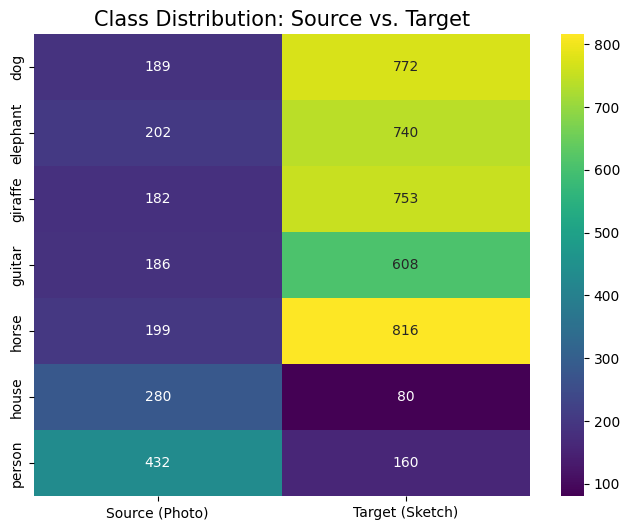

In [26]:
# --- Generate All Visualizations ---
plot_class_distribution_heatmap(source_data, target_data, class_names)

Generating t-SNE plot...


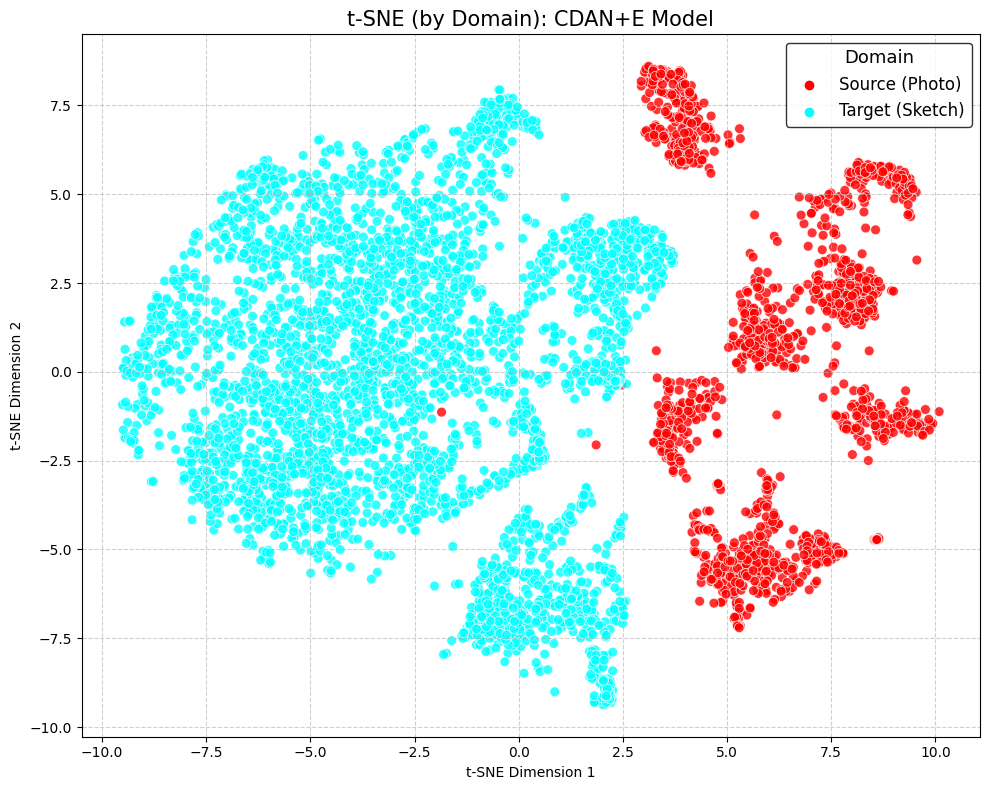

In [27]:
generate_tsne_plot(cdan_model_trained, source_loader, target_loader, "t-SNE (by Domain): CDAN+E Model")

Generating t-SNE plot (colored by class)...


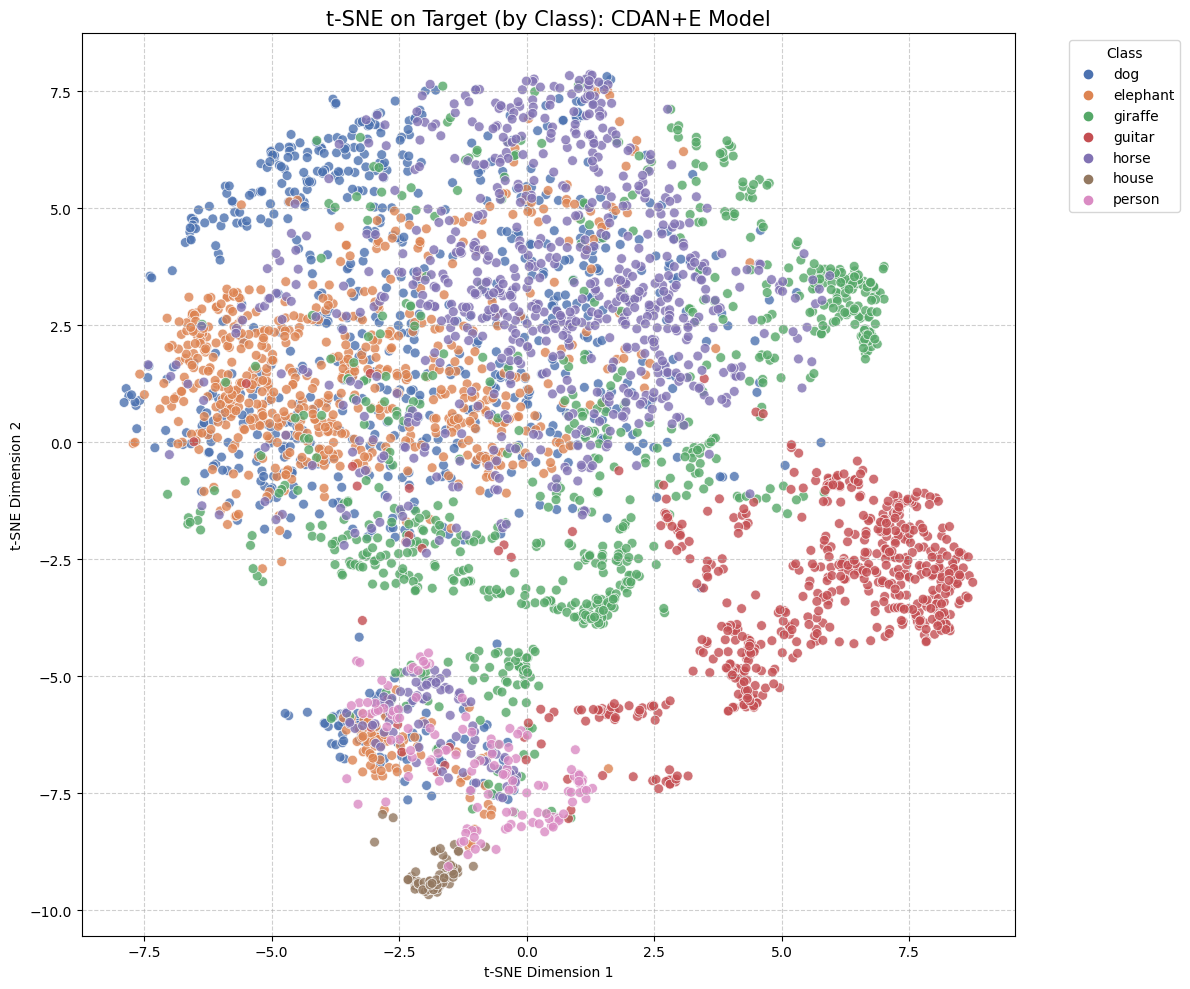

In [28]:
generate_tsne_by_class(cdan_model_trained, target_loader, "t-SNE on Target (by Class): CDAN+E Model")

Generating confusion matrix...


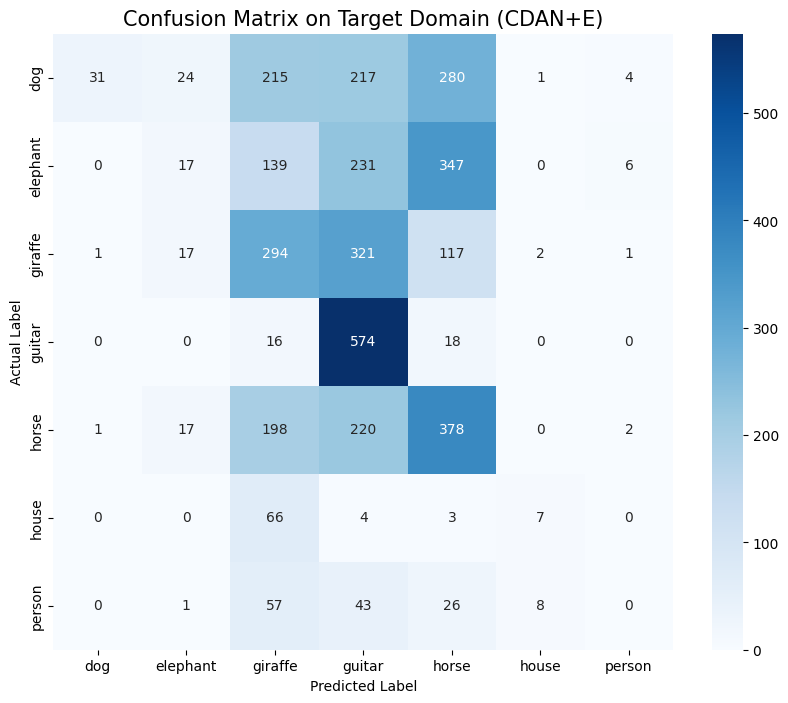

In [29]:
plot_confusion_matrix(cdan_model_trained, target_loader, class_names, "Confusion Matrix on Target Domain (CDAN+E)")

# Self-Training (Pseudo-Labels)


--- Generating Pseudo-Labels (Threshold: 0.95) ---
Generated 286 pseudo-labels.
Pseudo-Label Accuracy (vs. True Labels): 90.21%


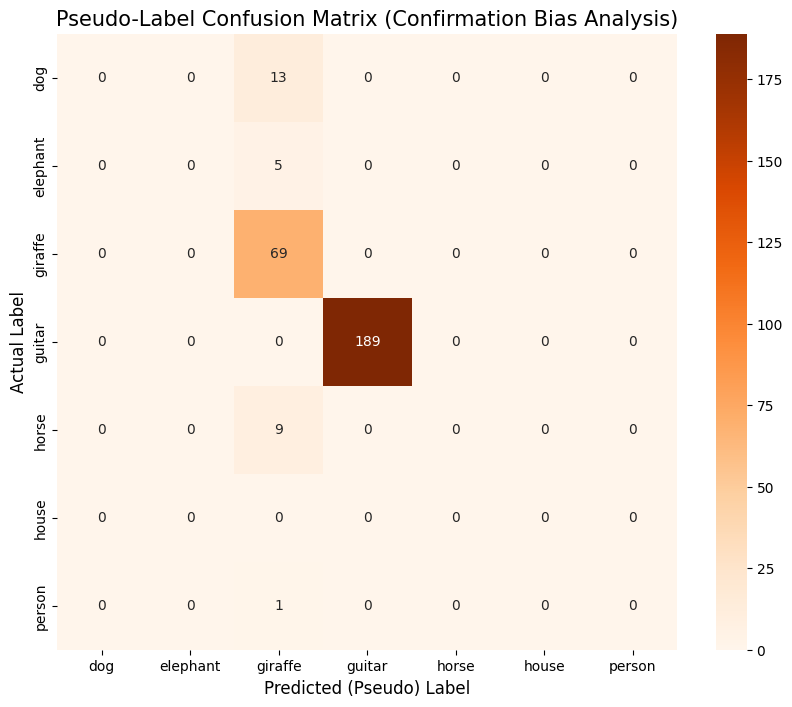

In [30]:
from sklearn.metrics import accuracy_score, confusion_matrix
import pandas as pd
import seaborn as sns

def generate_and_analyze_pseudo_labels(model, dataloader, device, confidence_threshold=0.95):
    """
    Generates pseudo-labels and analyzes them for accuracy and confirmation bias.
    """
    print(f"\n--- Generating Pseudo-Labels (Threshold: {confidence_threshold}) ---")
    model.eval()
    
    high_conf_inputs, pseudo_labels, true_labels_for_analysis = [], [], []
    
    with torch.no_grad():
        for batch in dataloader:
            inputs, labels = batch['pixel_values'].to(device), batch['label'].to(device)
            outputs = model(inputs)
            probabilities = torch.nn.functional.softmax(outputs, dim=1)
            confidences, preds = torch.max(probabilities, 1)
            
            high_conf_mask = confidences >= confidence_threshold
            
            high_conf_inputs.append(inputs[high_conf_mask].cpu())
            pseudo_labels.append(preds[high_conf_mask].cpu())
            true_labels_for_analysis.append(labels[high_conf_mask].cpu())
                
    if not high_conf_inputs:
        print("Warning: No pseudo-labels were generated. The confidence threshold might be too high.")
        return None, None

    all_high_conf_inputs = torch.cat(high_conf_inputs)
    all_pseudo_labels = torch.cat(pseudo_labels)
    all_true_labels = torch.cat(true_labels_for_analysis)
    
    print(f"Generated {len(all_pseudo_labels)} pseudo-labels.")
    
    # --- Analysis of Confirmation Bias ---
    pseudo_label_acc = accuracy_score(all_true_labels, all_pseudo_labels)
    print(f"Pseudo-Label Accuracy (vs. True Labels): {pseudo_label_acc:.2%}")
    
    # --- THIS IS THE FIX ---
    # Define the full list of labels (0 to 6)
    all_class_labels = list(range(len(class_names)))
    # Force the confusion matrix to use all 7 labels, creating a 7x7 matrix
    cm = confusion_matrix(all_true_labels, all_pseudo_labels, labels=all_class_labels)
    # -----------------------

    cm_df = pd.DataFrame(cm, index=class_names, columns=class_names)
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Oranges')
    plt.title("Pseudo-Label Confusion Matrix (Confirmation Bias Analysis)", fontsize=15)
    plt.ylabel('Actual Label', fontsize=12)
    plt.xlabel('Predicted (Pseudo) Label', fontsize=12)
    plt.show()
    
    pseudo_dataset = TensorDataset(all_high_conf_inputs, all_pseudo_labels)
    return pseudo_dataset, pseudo_label_acc

# --- Now, re-run the function call ---
pseudo_dataset, pseudo_label_accuracy = generate_and_analyze_pseudo_labels(
    baseline_model_trained, 
    target_loader, 
    device
)

In [31]:
import copy

if pseudo_dataset:
    # Create a dataloader for the new dataset
    pseudo_loader = DataLoader(pseudo_dataset, batch_size=BATCH_SIZE, shuffle=True)

    # --- Create a new model to fine-tune ---
    self_training_model = copy.deepcopy(baseline_model_trained)
    self_training_model = self_training_model.to(device)

    # --- Fine-tuning Loop ---
    print("\n--- Fine-tuning on Pseudo-Labels ---")
    
    # Fine-tune the whole model (not just the head) with a low LR
    for param in self_training_model.parameters():
        param.requires_grad = True
        
    optimizer = optim.SGD(self_training_model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0005)
    criterion = nn.CrossEntropyLoss()
    
    self_training_model.train()
    num_finetune_epochs = 5

    for epoch in range(num_finetune_epochs):
        for inputs, labels in pseudo_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            outputs = self_training_model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        
        print(f"Epoch {epoch+1}/{num_finetune_epochs}, Fine-tuning Loss: {loss.item():.4f}")

    print("--- Fine-tuning Complete ---")
else:
    print("Skipping fine-tuning as no pseudo-labels were generated.")
    self_training_model = None


--- Fine-tuning on Pseudo-Labels ---
Epoch 1/5, Fine-tuning Loss: 0.0419
Epoch 2/5, Fine-tuning Loss: 0.0022
Epoch 3/5, Fine-tuning Loss: 0.0093
Epoch 4/5, Fine-tuning Loss: 0.0549
Epoch 5/5, Fine-tuning Loss: 0.0001
--- Fine-tuning Complete ---



--- Comprehensive Analysis of Self-Training Model ---
Calculating Proxy-Distance for ResNet...
-> Proxy-Distance (Classifier Accuracy): 1.0000

--- FINAL Comprehensive Analysis Results ---
              Target Acc. Source Acc. Rare Class F1 Proxy-Distance
Baseline           32.83%     100.00%        0.3074        100.00%
DANN               50.72%      94.11%        0.5158         99.96%
DAN                40.50%      95.73%        0.4974        100.00%
CDAN+E             33.32%      98.50%        0.3605        100.00%
Self-Training      34.09%      16.95%        0.3092        100.00%
Generating t-SNE plot...


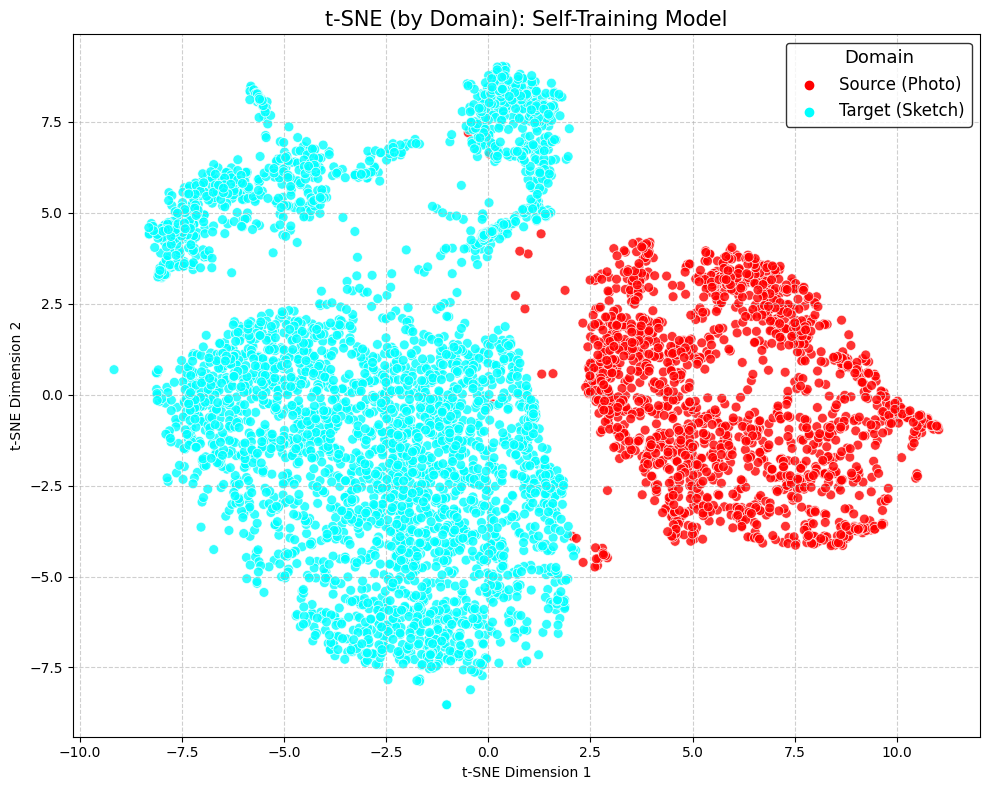

Generating t-SNE plot (colored by class)...


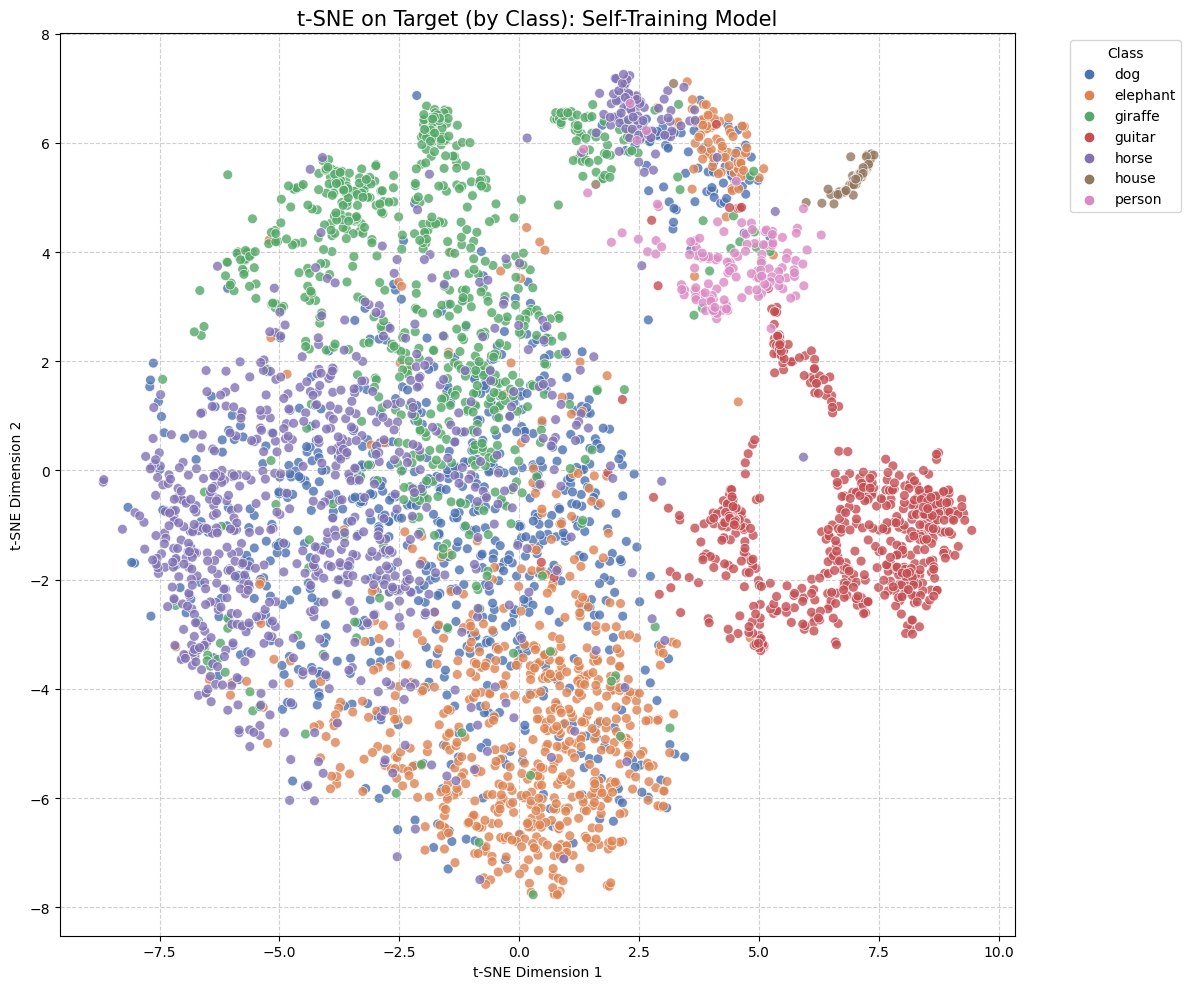

Generating confusion matrix...


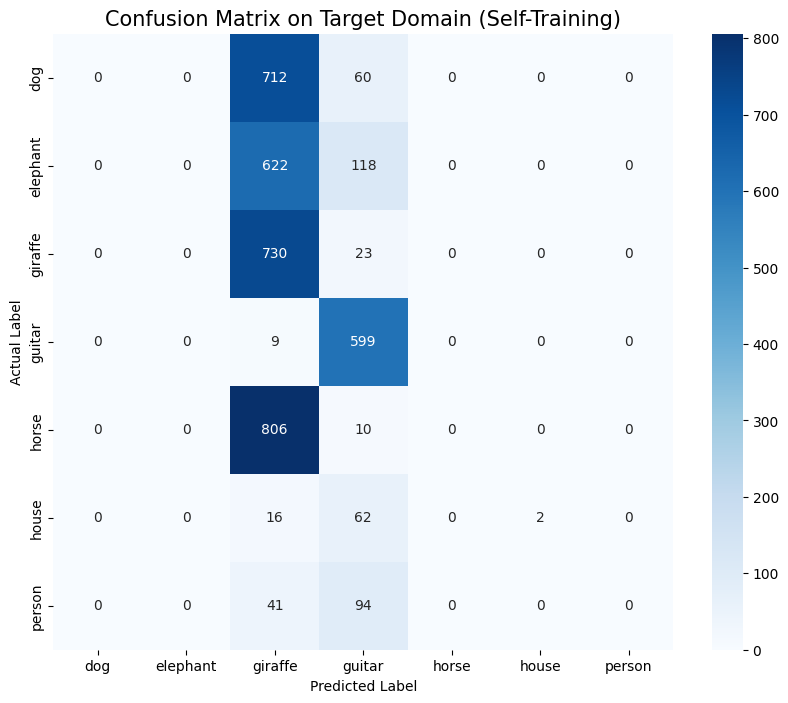

In [32]:
if self_training_model:
    print("\n--- Comprehensive Analysis of Self-Training Model ---")
    
    target_acc = evaluate_target_accuracy(self_training_model, target_loader, device)
    source_acc = calculate_source_accuracy(self_training_model, source_loader, device)
    rare_f1 = calculate_rare_f1(self_training_model, target_loader, rarest_class_indices, device)
    proxy_dist = calculate_proxy_distance(self_training_model, source_loader, target_loader, device)

    st_results = {'Self-Training': {
        'Target Acc.': f"{target_acc:.2%}", 'Source Acc.': f"{source_acc:.2%}",
        'Rare Class F1': f"{rare_f1:.4f}", 'Proxy-Distance': f"{proxy_dist:.2%}"
    }}
    
    st_df = pd.DataFrame(st_results).T
    results_df = pd.concat([results_df, st_df])
    print("\n--- FINAL Comprehensive Analysis Results ---")
    print(results_df)

    # --- Generate All Visualizations ---
    generate_tsne_plot(self_training_model, source_loader, target_loader, "t-SNE (by Domain): Self-Training Model")
    generate_tsne_by_class(self_training_model, target_loader, "t-SNE on Target (by Class): Self-Training Model")
    plot_confusion_matrix(self_training_model, target_loader, class_names, "Confusion Matrix on Target Domain (Self-Training)")
else:
    print("Cannot evaluate Self-Training model as it was not trained.")

### Fix: Joint Training on Original Data and Pseudo Labeled Data

In [33]:
# We already have the function defined
# pseudo_dataset, _ = generate_and_analyze_pseudo_labels(...)
# We will use the 'pseudo_dataset' variable from the previous step.

if pseudo_dataset:
    pseudo_loader = DataLoader(pseudo_dataset, batch_size=BATCH_SIZE, shuffle=True)
    print(f"Created a DataLoader with {len(pseudo_dataset)} pseudo-samples.")
else:
    print("Error: Pseudo-dataset is empty.")

Created a DataLoader with 286 pseudo-samples.


In [34]:
import copy

def train_self_training_jointly(baseline_model, source_loader, pseudo_loader, device, num_epochs=15):
    """
    Trains a model jointly on source data (to prevent forgetting)
    and pseudo-labeled data (to adapt).
    """
    print("\n--- Starting Joint Self-Training (Corrected Method) ---")
    
    # Create a deep copy to fine-tune
    model = copy.deepcopy(baseline_model)
    model.train()

    # Unfreeze all layers and set up the optimizer
    for param in model.parameters():
        param.requires_grad = True
    optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0005)
    criterion = nn.CrossEntropyLoss()

    len_dataloader = min(len(source_loader), len(pseudo_loader))

    for epoch in range(num_epochs):
        for i, (source_batch, pseudo_batch) in enumerate(zip(source_loader, pseudo_loader)):
            
            # --- 1. Source Data Batch (Prevents Forgetting) ---
            source_inputs, source_labels = source_batch['pixel_values'].to(device), source_batch['label'].to(device)
            
            # --- 2. Pseudo-Labeled Batch (Adapts) ---
            pseudo_inputs, pseudo_labels = pseudo_batch[0].to(device), pseudo_batch[1].to(device)
            
            # Combine inputs and labels
            inputs = torch.cat([source_inputs, pseudo_inputs])
            labels = torch.cat([source_labels, pseudo_labels])
            
            # --- 3. Joint Optimization Step ---
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
        print(f"Epoch {epoch+1}/{num_epochs}, Joint Loss: {loss.item():.4f}")

    print("--- Joint Self-Training Complete ---")
    return model

# --- Run the corrected training ---
if pseudo_dataset:
    self_training_model = train_self_training_jointly(baseline_model_trained, source_loader, pseudo_loader, device)
else:
    self_training_model = None


--- Starting Joint Self-Training (Corrected Method) ---
Epoch 1/15, Joint Loss: 0.0495
Epoch 2/15, Joint Loss: 0.0630
Epoch 3/15, Joint Loss: 0.0187
Epoch 4/15, Joint Loss: 0.0233
Epoch 5/15, Joint Loss: 0.0073
Epoch 6/15, Joint Loss: 0.0043
Epoch 7/15, Joint Loss: 0.0020
Epoch 8/15, Joint Loss: 0.0045
Epoch 9/15, Joint Loss: 0.0053
Epoch 10/15, Joint Loss: 0.0038
Epoch 11/15, Joint Loss: 0.0075
Epoch 12/15, Joint Loss: 0.0012
Epoch 13/15, Joint Loss: 0.0090
Epoch 14/15, Joint Loss: 0.0023
Epoch 15/15, Joint Loss: 0.0021
--- Joint Self-Training Complete ---



--- Comprehensive Analysis of Joint Self-Training Model ---
Calculating Proxy-Distance for ResNet...
-> Proxy-Distance (Classifier Accuracy): 1.0000

--- FINAL Comprehensive Analysis Results ---
                      Target Acc. Source Acc. Rare Class F1 Proxy-Distance
Baseline                   32.83%     100.00%        0.3074        100.00%
DANN                       50.72%      94.11%        0.5158         99.96%
DAN                        40.50%      95.73%        0.4974        100.00%
CDAN+E                     33.32%      98.50%        0.3605        100.00%
Self-Training (Joint)      33.38%      99.94%        0.3492        100.00%
Generating t-SNE plot...


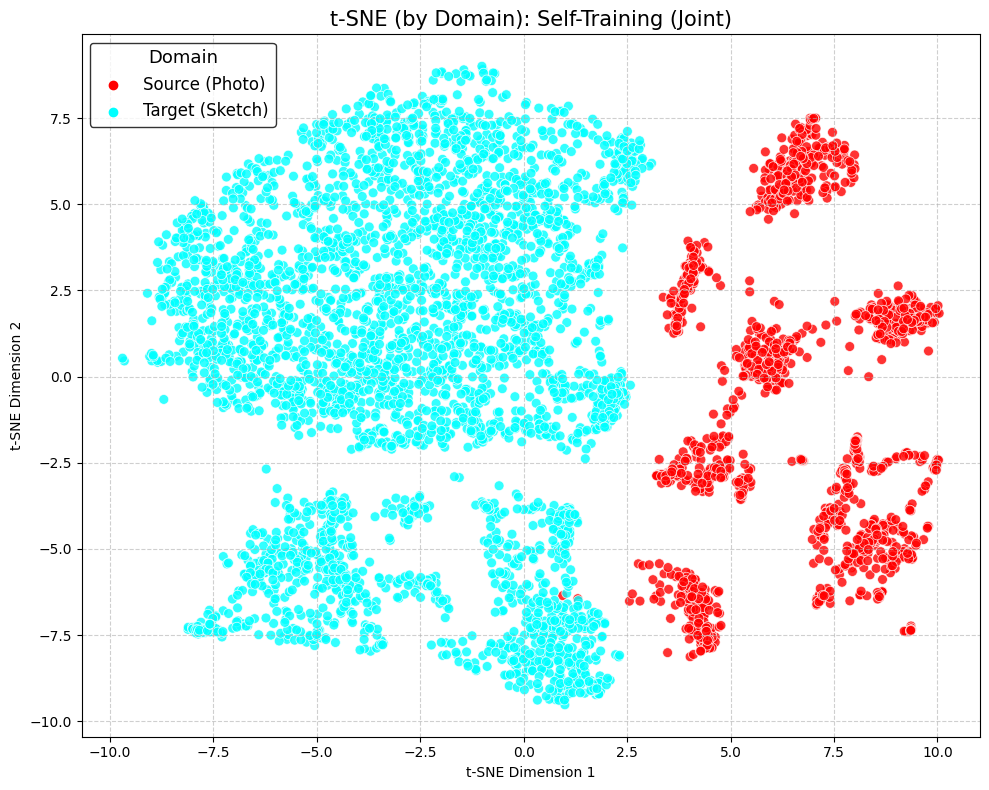

Generating t-SNE plot (colored by class)...


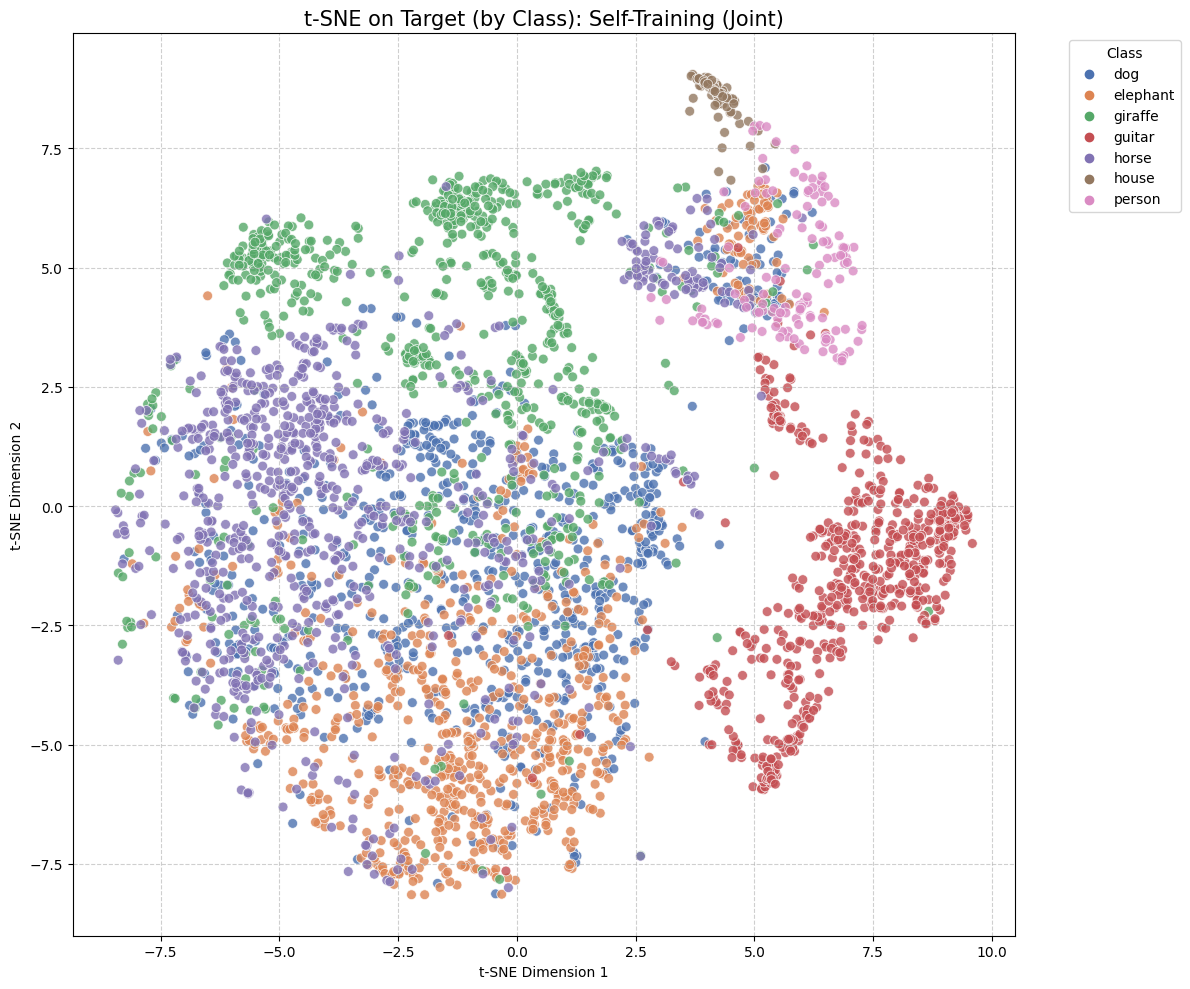

Generating confusion matrix...


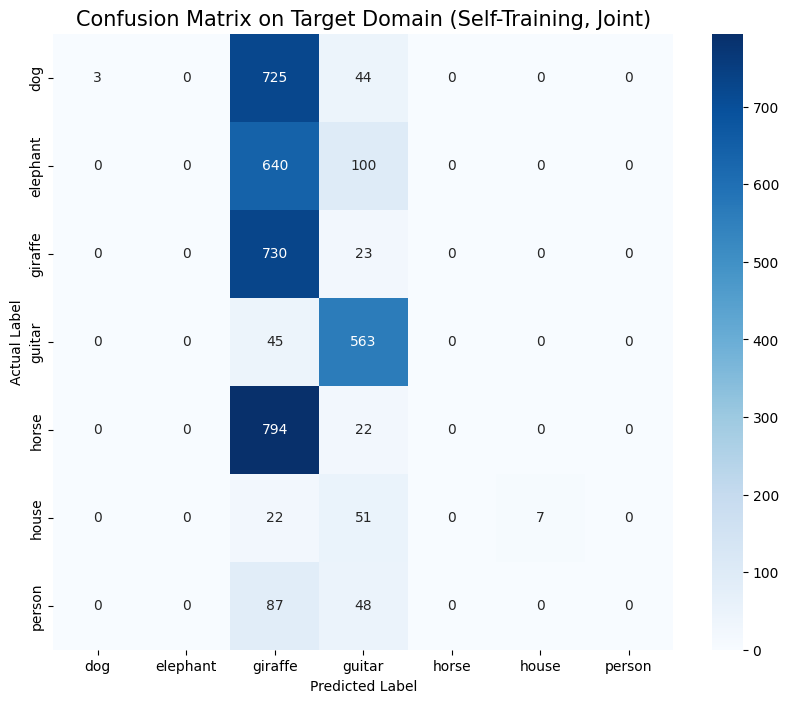

In [35]:
if self_training_model:
    print("\n--- Comprehensive Analysis of Joint Self-Training Model ---")
    
    target_acc = evaluate_target_accuracy(self_training_model, target_loader, device)
    source_acc = calculate_source_accuracy(self_training_model, source_loader, device)
    rare_f1 = calculate_rare_f1(self_training_model, target_loader, rarest_class_indices, device)
    proxy_dist = calculate_proxy_distance(self_training_model, source_loader, target_loader, device)

    st_results = {'Self-Training (Joint)': {
        'Target Acc.': f"{target_acc:.2%}", 'Source Acc.': f"{source_acc:.2%}",
        'Rare Class F1': f"{rare_f1:.4f}", 'Proxy-Distance': f"{proxy_dist:.2%}"
    }}
    
    st_df = pd.DataFrame(st_results).T
    # This will replace the previous failed Self-Training run
    results_df = results_df.drop('Self-Training', errors='ignore') 
    results_df = pd.concat([results_df, st_df])
    
    print("\n--- FINAL Comprehensive Analysis Results ---")
    print(results_df)

    # --- Generate All Visualizations ---
    generate_tsne_plot(self_training_model, source_loader, target_loader, "t-SNE (by Domain): Self-Training (Joint)")
    generate_tsne_by_class(self_training_model, target_loader, "t-SNE on Target (by Class): Self-Training (Joint)")
    plot_confusion_matrix(self_training_model, target_loader, class_names, "Confusion Matrix on Target Domain (Self-Training, Joint)")
else:
    print("Cannot evaluate Self-Training model as it was not trained.")

# Concept Shift (Mild)

In [36]:
# The class name 'giraffe' corresponds to label index 2 in our dataset.
GIRAFFE_CLASS_INDEX = 2
DOWNSAMPLE_FRACTION = 0.1 # Keep only 10% of the 'giraffe' samples

print(f"Creating a new target dataset with label shift...")
print(f"Downsampling class '{class_names[GIRAFFE_CLASS_INDEX]}' (index {GIRAFFE_CLASS_INDEX}) by 90%.")

# Filter the dataset
def filter_giraffe(example, idx):
    if example['label'] == GIRAFFE_CLASS_INDEX:
        # Keep only 10% of the giraffe samples
        return idx % (1/DOWNSAMPLE_FRACTION) < 1
    return True

# Create the new shifted target dataset
target_data_shifted = target_data.filter(filter_giraffe, with_indices=True)

# Create the new, robust dataloader for this shifted data
target_loader_shifted = DataLoader(
    target_data_shifted,
    batch_size=BATCH_SIZE,
    shuffle=False, # No shuffling for evaluation
    collate_fn=custom_collate_fn,
    drop_last=True
)

# We also need a shuffled version for training the DA models
target_loader_shifted_train = DataLoader(
    target_data_shifted,
    batch_size=BATCH_SIZE,
    shuffle=True, # Shuffled for training
    collate_fn=custom_collate_fn,
    drop_last=True
)

print(f"Original target size: {len(target_data)}, Shifted target size: {len(target_data_shifted)}")

Creating a new target dataset with label shift...
Downsampling class 'giraffe' (index 2) by 90%.


Filter:   0%|          | 0/3929 [00:00<?, ? examples/s]

Original target size: 3929, Shifted target size: 3251


In [37]:
# Create a new DataFrame for this experiment
results_shift_data = {}

# --- 1. Re-evaluate the Baseline on the Shifted Data ---
# We don't need to re-train the baseline, just evaluate it.
print("\n--- Analyzing Baseline on Shifted Data ---")
baseline_model_trained.eval() # Ensure it's in eval mode
target_acc_shift = evaluate_target_accuracy(baseline_model_trained, target_loader_shifted, device)
source_acc_shift = calculate_source_accuracy(baseline_model_trained, source_loader, device) # This will be the same
rare_f1_shift = calculate_rare_f1(baseline_model_trained, target_loader_shifted, [GIRAFFE_CLASS_INDEX], device)
proxy_dist_shift = calculate_proxy_distance(baseline_model_trained, source_loader, target_loader_shifted, device)

results_shift_data['Baseline (Shifted)'] = {
    'Target Acc.': f"{target_acc_shift:.2%}", 'Source Acc.': f"{source_acc_shift:.2%}",
    'Rare Class F1 (giraffe)': f"{rare_f1_shift:.4f}", 'Proxy-Distance': f"{proxy_dist_shift:.2%}"
}


--- Analyzing Baseline on Shifted Data ---
Calculating Proxy-Distance for ResNet...
-> Proxy-Distance (Classifier Accuracy): 1.0000


In [38]:
# --- 2. Re-train DANN on Shifted Data ---
print("\n--- Re-training DANN on Shifted Data ---")
dann_model_shift = DANN_Model(num_classes=num_classes).to(device)
dann_model_shift_trained = train_dann(dann_model_shift, source_loader, target_loader_shifted_train, device, num_epochs=15)
target_acc_shift = evaluate_target_accuracy(dann_model_shift_trained, target_loader_shifted, device)
source_acc_shift = calculate_source_accuracy(dann_model_shift_trained, source_loader, device)
rare_f1_shift = calculate_rare_f1(dann_model_shift_trained, target_loader_shifted, [GIRAFFE_CLASS_INDEX], device)
proxy_dist_shift = calculate_proxy_distance(dann_model_shift_trained, source_loader, target_loader_shifted, device)

results_shift_data['DANN (Shifted)'] = {
    'Target Acc.': f"{target_acc_shift:.2%}", 'Source Acc.': f"{source_acc_shift:.2%}",
    'Rare Class F1 (giraffe)': f"{rare_f1_shift:.4f}", 'Proxy-Distance': f"{proxy_dist_shift:.2%}"
}


--- Re-training DANN on Shifted Data ---

--- Starting DANN Training ---
Epoch [1/15], Class Loss: 0.1379, Domain Loss: 0.5387
Epoch [2/15], Class Loss: 0.0481, Domain Loss: 0.3702
Epoch [3/15], Class Loss: 0.1410, Domain Loss: 1.1607
Epoch [4/15], Class Loss: 0.0483, Domain Loss: 1.2522
Epoch [5/15], Class Loss: 0.0244, Domain Loss: 1.2703
Epoch [6/15], Class Loss: 0.0422, Domain Loss: 1.2077
Epoch [7/15], Class Loss: 0.0634, Domain Loss: 1.2949
Epoch [8/15], Class Loss: 0.0373, Domain Loss: 1.2456
Epoch [9/15], Class Loss: 0.0091, Domain Loss: 1.2939
Epoch [10/15], Class Loss: 0.0050, Domain Loss: 1.3016
Epoch [11/15], Class Loss: 0.0122, Domain Loss: 1.3648
Epoch [12/15], Class Loss: 0.0051, Domain Loss: 1.2966
Epoch [13/15], Class Loss: 0.0071, Domain Loss: 1.3663
Epoch [14/15], Class Loss: 0.0102, Domain Loss: 1.3537
Epoch [15/15], Class Loss: 0.0039, Domain Loss: 1.2909
--- DANN Training Complete ---
Calculating Proxy-Distance for DANN_Model...
-> Proxy-Distance (Classifier Accu

In [39]:
# --- 3. Re-train DAN on Shifted Data ---
print("\n--- Re-training DAN on Shifted Data ---")
dan_model_shift = DAN_Model(num_classes=num_classes).to(device)
dan_model_shift_trained = train_dan_stable(dan_model_shift, source_loader, target_loader_shifted_train, device, num_epochs=15)
target_acc_shift = evaluate_target_accuracy(dan_model_shift_trained, target_loader_shifted, device)
source_acc_shift = calculate_source_accuracy(dan_model_shift_trained, source_loader, device)
rare_f1_shift = calculate_rare_f1(dan_model_shift_trained, target_loader_shifted, [GIRAFFE_CLASS_INDEX], device)
proxy_dist_shift = calculate_proxy_distance(dan_model_shift_trained, source_loader, target_loader_shifted, device)

results_shift_data['DAN (Shifted)'] = {
    'Target Acc.': f"{target_acc_shift:.2%}", 'Source Acc.': f"{source_acc_shift:.2%}",
    'Rare Class F1 (giraffe)': f"{rare_f1_shift:.4f}", 'Proxy-Distance': f"{proxy_dist_shift:.2%}"
}


--- Re-training DAN on Shifted Data ---

--- Starting Final, Stable DAN Training ---
Epoch [1/15], Class Loss: 0.0497, Stable MMD (Features): 0.1665, Stable MMD (Classifier): 0.1200
Epoch [2/15], Class Loss: 0.0882, Stable MMD (Features): 0.1487, Stable MMD (Classifier): 0.2063
Epoch [3/15], Class Loss: 0.0435, Stable MMD (Features): 0.1410, Stable MMD (Classifier): 0.1211
Epoch [4/15], Class Loss: 0.0369, Stable MMD (Features): 0.1319, Stable MMD (Classifier): 0.0889
Epoch [5/15], Class Loss: 0.0646, Stable MMD (Features): 0.1311, Stable MMD (Classifier): 0.1093
Epoch [6/15], Class Loss: 0.0447, Stable MMD (Features): 0.1332, Stable MMD (Classifier): 0.0855
Epoch [7/15], Class Loss: 0.0557, Stable MMD (Features): 0.1296, Stable MMD (Classifier): 0.0927
Epoch [8/15], Class Loss: 0.0860, Stable MMD (Features): 0.1317, Stable MMD (Classifier): 0.1164
Epoch [9/15], Class Loss: 0.0535, Stable MMD (Features): 0.1314, Stable MMD (Classifier): 0.1545
Epoch [10/15], Class Loss: 0.0365, Stable


--- Re-running Self-Training on Shifted Data ---

--- Generating Pseudo-Labels (Threshold: 0.95) ---
Generated 224 pseudo-labels.
Pseudo-Label Accuracy (vs. True Labels): 87.50%


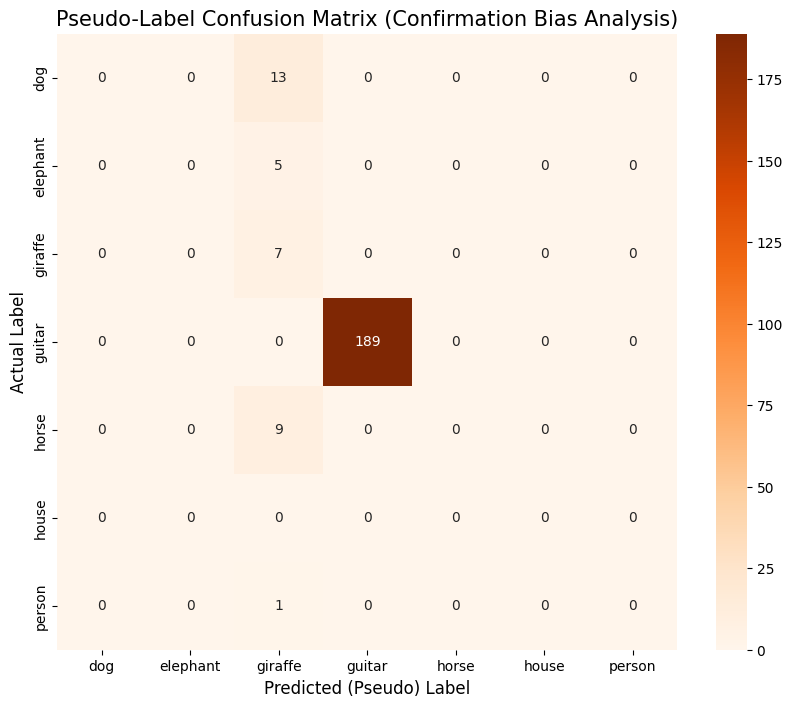


--- Starting Joint Self-Training (Corrected Method) ---
Epoch 1/15, Joint Loss: 0.0648
Epoch 2/15, Joint Loss: 0.0335
Epoch 3/15, Joint Loss: 0.0114
Epoch 4/15, Joint Loss: 0.0279
Epoch 5/15, Joint Loss: 0.0072
Epoch 6/15, Joint Loss: 0.0018
Epoch 7/15, Joint Loss: 0.0031
Epoch 8/15, Joint Loss: 0.0025
Epoch 9/15, Joint Loss: 0.0048
Epoch 10/15, Joint Loss: 0.0159
Epoch 11/15, Joint Loss: 0.0027
Epoch 12/15, Joint Loss: 0.0067
Epoch 13/15, Joint Loss: 0.0042
Epoch 14/15, Joint Loss: 0.0063
Epoch 15/15, Joint Loss: 0.0019
--- Joint Self-Training Complete ---
Calculating Proxy-Distance for ResNet...
-> Proxy-Distance (Classifier Accuracy): 1.0000


In [40]:
# --- 4. Re-run Self-Training on Shifted Data ---
print("\n--- Re-running Self-Training on Shifted Data ---")
pseudo_dataset_shift, _ = generate_and_analyze_pseudo_labels(baseline_model_trained, target_loader_shifted, device)
if pseudo_dataset_shift:
    pseudo_loader_shift = DataLoader(pseudo_dataset_shift, batch_size=BATCH_SIZE, shuffle=True)
    st_model_shift_trained = train_self_training_jointly(baseline_model_trained, source_loader, pseudo_loader_shift, device)
    
    target_acc_shift = evaluate_target_accuracy(st_model_shift_trained, target_loader_shifted, device)
    source_acc_shift = calculate_source_accuracy(st_model_shift_trained, source_loader, device)
    rare_f1_shift = calculate_rare_f1(st_model_shift_trained, target_loader_shifted, [GIRAFFE_CLASS_INDEX], device)
    proxy_dist_shift = calculate_proxy_distance(st_model_shift_trained, source_loader, target_loader_shifted, device)
else:
    print("Self-Training failed to generate labels, logging as 0.")
    target_acc_shift, source_acc_shift, rare_f1_shift, proxy_dist_shift = 0, 0, 0, 0

results_shift_data['Self-Training (Shifted)'] = {
    'Target Acc.': f"{target_acc_shift:.2%}", 'Source Acc.': f"{source_acc_shift:.2%}",
    'Rare Class F1 (giraffe)': f"{rare_f1_shift:.4f}", 'Proxy-Distance': f"{proxy_dist_shift:.2%}"
}



--- Comprehensive Analysis Results (Concept Shift Scenario) ---
                        Target Acc. Source Acc. Rare Class F1 (giraffe)  \
Baseline (Shifted)           21.66%     100.00%                  0.9510   
DANN (Shifted)               43.66%      93.75%                  0.5577   
DAN (Shifted)                45.14%      96.94%                  0.5149   
Self-Training (Shifted)      20.85%      99.94%                  0.9583   

                        Proxy-Distance  
Baseline (Shifted)             100.00%  
DANN (Shifted)                  99.94%  
DAN (Shifted)                  100.00%  
Self-Training (Shifted)        100.00%  

--- Generating Confusion Matrices for Concept Shift Analysis ---
Generating confusion matrix...


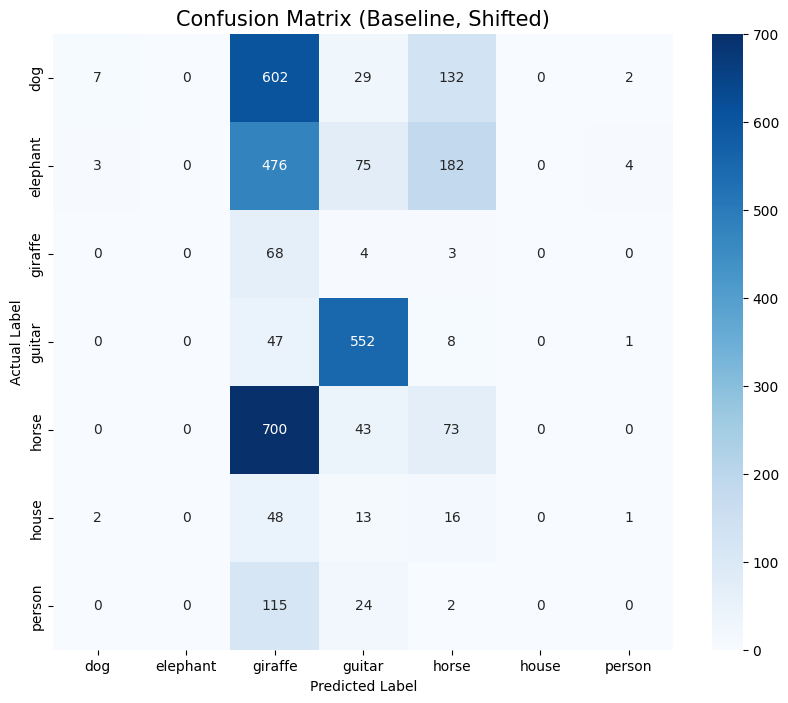

Generating confusion matrix...


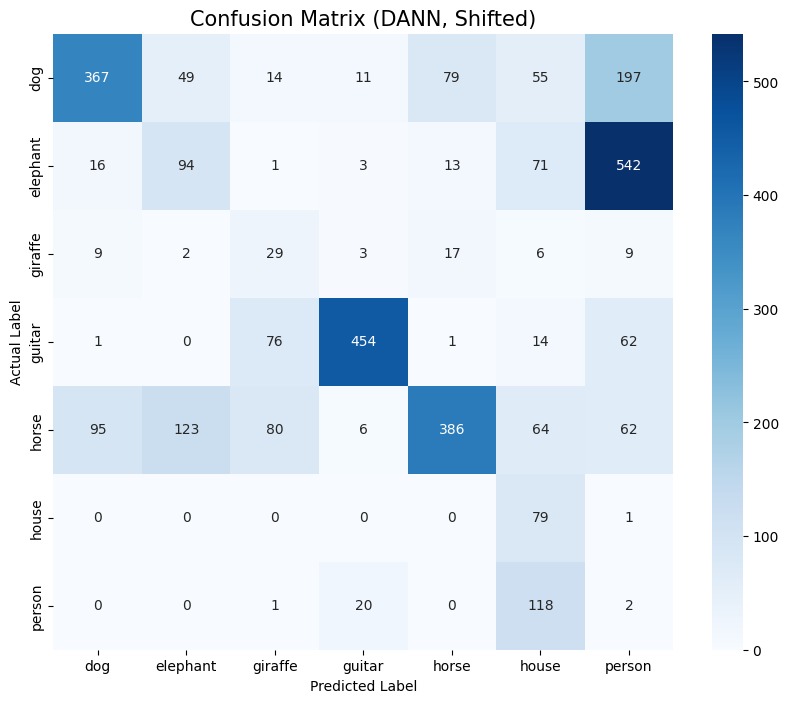

Generating confusion matrix...


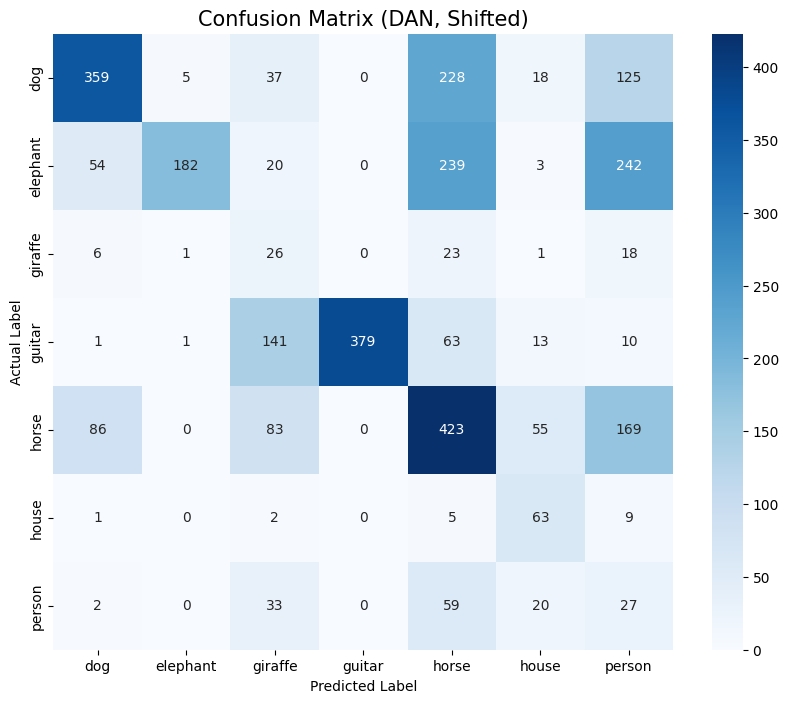

Generating confusion matrix...


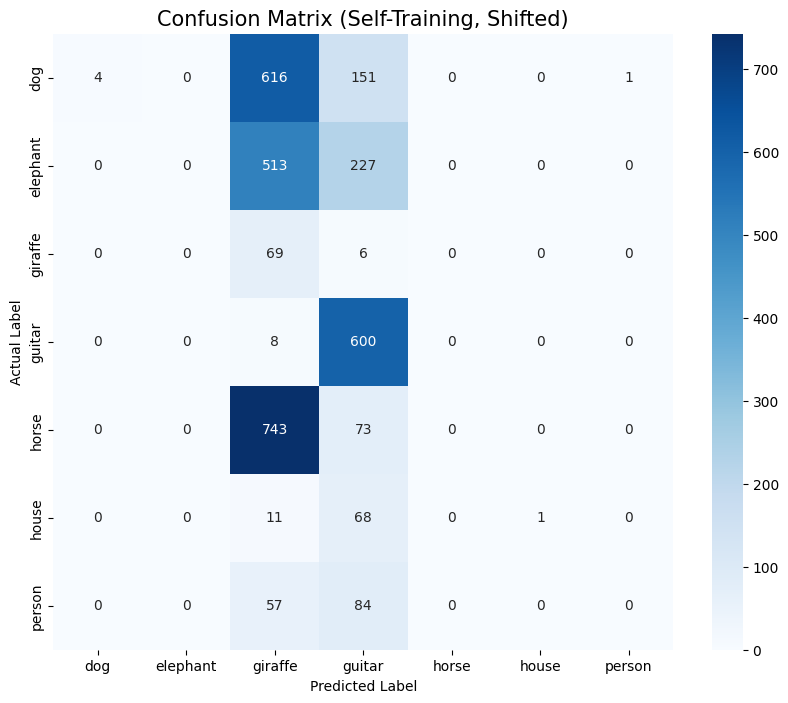


--- Generating t-SNE for best model (DAN (Shifted)) ---
Generating t-SNE plot (colored by class)...


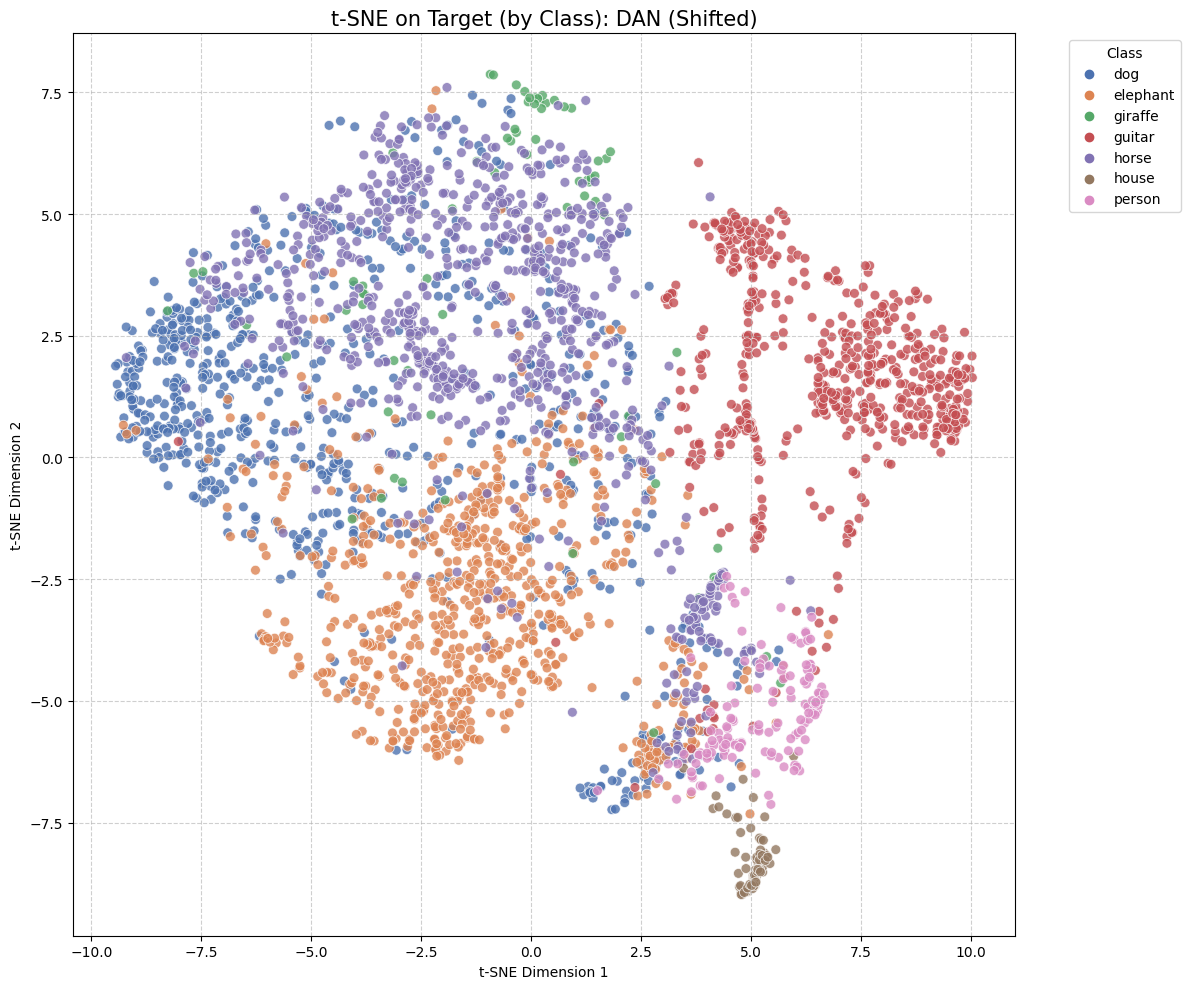

In [41]:
# --- Display Final Concept Shift Results Table ---
results_shift_df = pd.DataFrame(results_shift_data).T
print("\n\n--- Comprehensive Analysis Results (Concept Shift Scenario) ---")
print(results_shift_df)

# --- Generate All Visualizations ---
print("\n--- Generating Confusion Matrices for Concept Shift Analysis ---")
# This is the most critical analysis
plot_confusion_matrix(baseline_model_trained, target_loader_shifted, class_names, "Confusion Matrix (Baseline, Shifted)")
plot_confusion_matrix(dann_model_shift_trained, target_loader_shifted, class_names, "Confusion Matrix (DANN, Shifted)")
plot_confusion_matrix(dan_model_shift_trained, target_loader_shifted, class_names, "Confusion Matrix (DAN, Shifted)")
if 'st_model_shift_trained' in locals():
    plot_confusion_matrix(st_model_shift_trained, target_loader_shifted, class_names, "Confusion Matrix (Self-Training, Shifted)")

# Also visualize the class structure for the best-performing model
# We will determine the best model from the table above
best_model_name = results_shift_df['Target Acc.'].idxmax()
best_model = {
    'Baseline (Shifted)': baseline_model_trained,
    'DANN (Shifted)': dann_model_shift_trained,
    'DAN (Shifted)': dan_model_shift_trained,
    'Self-Training (Shifted)': st_model_shift_trained
}[best_model_name]

print(f"\n--- Generating t-SNE for best model ({best_model_name}) ---")
generate_tsne_by_class(best_model, target_loader_shifted, f"t-SNE on Target (by Class): {best_model_name}")